In [1]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- CONFIGURATION ---
sf.hbar = 1

# Parameters
eta, delta = 0.95, 0.02
num_steps = 200
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)

learning_rate_mu = 0.0005
learning_rate_epsilon = 0.003


def db_to_epsilon(db_val):
    """Convert squeezing in dB to epsilon."""
    t = 10.0 ** (-db_val / 10.0)
    return 0.5 * np.log((1.0 + t) / (1.0 - t))

def epsilon_to_db(epsilon: float) -> float:
    """Convert epsilon to dB value"""
    t = np.tanh(epsilon)
    return -10.0 * np.log10(t)

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)
    return wigner_avg

def marginal_from_wigner(W, xvec, phi):
    """Compute marginal distribution from the Wigner function at angle phi."""
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]

    X = Q * np.cos(phi) + P * np.sin(phi)

    bin_indices = np.floor((X - xvec[0]) / dq).astype(int)
    valid_bins = (bin_indices >= 0) & (bin_indices < len(xvec))

    P_x_mu = np.bincount(bin_indices[valid_bins].ravel(),
                         weights=W[valid_bins].ravel() * dq**2,
                         minlength=len(xvec))

    norm = np.trapz(P_x_mu, xvec)
    if norm > 1e-15:
        P_x_mu /= norm
    return P_x_mu


def classical_fisher(mu, epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Calculate the 2x2 classical Fisher information matrix w.r.t. (eta, delta),
    given the homodyne measurement of quadrature x_mu.
    """
    # Base Wigner
    W_base = prepare_gkp_state(epsilon, eta, delta)
    P_mu = marginal_from_wigner(W_base, quad_axis, mu) + 1e-12

    # dP/d_eta
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta, delta)
    P_eta_plus = marginal_from_wigner(W_eta_plus, quad_axis, mu) + 1e-12
    dP_eta = (P_eta_plus - P_mu) / d_eta

    # dP/d_delta
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta)
    P_delta_plus = marginal_from_wigner(W_delta_plus, quad_axis, mu) + 1e-12
    dP_delta = (P_delta_plus - P_mu) / d_delta

    # Fisher matrix
    F_eta_eta = np.trapz((dP_eta**2) / P_mu, quad_axis)
    F_delta_delta = np.trapz((dP_delta**2) / P_mu, quad_axis)
    F_eta_delta = np.trapz((dP_eta * dP_delta) / P_mu, quad_axis)

    return np.array([[F_eta_eta, F_eta_delta],
                     [F_eta_delta, F_delta_delta]])

def fisher_det_mu(mu, epsilon, eta, delta):
    """To return det(F) for given mu."""
    F = classical_fisher(mu, epsilon, eta, delta)
    return np.linalg.det(F)

def compute_wigner_derivatives(epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Compute the derivatives of Wigner function with respect to eta and delta
    using central difference method
    """
    # Base Wigner function
    W_base = prepare_gkp_state(epsilon, eta, delta)
    
    # Compute dW/deta using central difference
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta/2, delta)
    W_eta_minus = prepare_gkp_state(epsilon, eta - d_eta/2, delta)
    dW_deta = (W_eta_plus - W_eta_minus) / d_eta
    
    # Compute dW/ddelta using central difference
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta/2)
    W_delta_minus = prepare_gkp_state(epsilon, eta, delta - d_delta/2)
    dW_ddelta = (W_delta_plus - W_delta_minus) / d_delta
    
    return W_base, dW_deta, dW_ddelta




# Additional helper function for marginal MSE calculation clearly:
def marginal_mse(epsilon, mu, eta, delta):
    W_ideal = prepare_gkp_state(epsilon, eta=1.0, gamma=0.0)
    W_noisy = prepare_gkp_state(epsilon, eta=eta, gamma=delta)

    P_ideal = marginal_from_wigner(W_ideal, quad_axis, phi=mu)
    P_noisy = marginal_from_wigner(W_noisy, quad_axis, phi=mu)

    mse = np.trapz((P_noisy - P_ideal)**2, quad_axis)
    return mse


def compute_qfi_bound(dW_deta, dW_ddelta):
    """
    Compute the QFI bound using Wigner function derivatives
    For multi-parameter case: F_total = F_eta_eta + F_delta_delta
    """
    dq = quad_axis[1] - quad_axis[0]
    dp = dq
    
    # Compute F_eta_eta ≤ 4π∫(∂_η W)² dq dp
    F_eta_eta = 4 * np.pi * np.sum(dW_deta**2) * dq * dp
    
    # Compute F_delta_delta ≤ 4π∫(∂_δ W)² dq dp
    F_delta_delta = 4 * np.pi * np.sum(dW_ddelta**2) * dq * dp
    
    # Total QFI (trace of QFI matrix)
    F_total = F_eta_eta + F_delta_delta
    
    return F_total, F_eta_eta, F_delta_delta

def compute_qfi_gradient(epsilon, eta, delta, d_epsilon=1e-3):
    """
    Compute the gradient of the QFI bound with respect to epsilon
    using central difference method
    """
    # Compute QFI at epsilon + d_epsilon/2
    _, dW_deta_plus, dW_ddelta_plus = compute_wigner_derivatives(
        epsilon + d_epsilon/2, eta, delta)
    F_total_plus, _, _ = compute_qfi_bound(dW_deta_plus, dW_ddelta_plus)
    
    # Compute QFI at epsilon - d_epsilon/2
    _, dW_deta_minus, dW_ddelta_minus = compute_wigner_derivatives(
        epsilon - d_epsilon/2, eta, delta)
    F_total_minus, _, _ = compute_qfi_bound(dW_deta_minus, dW_ddelta_minus)
    
    # Compute gradient
    grad_epsilon = (F_total_plus - F_total_minus) / d_epsilon
    
    return grad_epsilon



c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [14]:

print(f"eta = {eta} and gamma = {delta}")
# --- Initialization ---
epsilon = db_to_epsilon(15)
epsilon_min, epsilon_max = db_to_epsilon(16), db_to_epsilon(10)
mu = 2.3592999716910443  # initial mu

# History recording
epsilon_history, mu_history = [], []
mse_history = []
cfi_history, qfi_history = [], []

velocity_mu, velocity_epsilon = 0, 0
momentum = 0.9

# --- Joint Optimization Loop ---
for step in tqdm(range(num_steps)):
    # --- Compute gradient for mu via CFI ---
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    velocity_mu = momentum * velocity_mu + learning_rate_mu * grad_mu
    mu += velocity_mu
    mu %= (2 * np.pi)

    # --- Compute gradient for epsilon via QFI ---
    grad_epsilon = compute_qfi_gradient(epsilon, eta, delta)
    grad_epsilon = np.clip(grad_epsilon, -0.05, 0.05)

    velocity_epsilon = momentum * velocity_epsilon + learning_rate_epsilon * grad_epsilon
    epsilon += velocity_epsilon
    epsilon = np.clip(epsilon, epsilon_min, epsilon_max)

    # --- Evaluate Fisher information ---
    F_cfi = classical_fisher(mu, epsilon, eta, delta)
    det_F_cfi = np.linalg.det(F_cfi)
    cfi_history.append(det_F_cfi)

    _, dW_deta, dW_ddelta = compute_wigner_derivatives(epsilon, eta, delta)
    F_qfi, _, _ = compute_qfi_bound(dW_deta, dW_ddelta)
    qfi_history.append(F_qfi)

    # --- Marginal MSE ---
    mse = marginal_mse(epsilon, mu, eta, delta)
    mse_history.append(mse)

    epsilon_history.append(epsilon)
    mu_history.append(mu)

    if step % 1 == 0 or step == num_steps - 1:
        db_val = epsilon_to_db(epsilon)
        print(f"Step {step}: mu={mu:.4f}, ε={epsilon:.4f} ({db_val:.2f} dB), "
              f"CFI_det={det_F_cfi:.4e}, QFI={F_qfi:.4e}, MSE={mse:.4e}")



eta = 0.95 and gamma = 0.02


  0%|          | 1/200 [25:20<84:02:59, 1520.50s/it]

Step 0: mu=2.3593, ε=0.0318 (14.98 dB), CFI_det=2.2119e+03, QFI=1.0542e+02, MSE=1.3203e-01


  1%|          | 2/200 [52:25<87:01:25, 1582.25s/it]

Step 1: mu=2.3593, ε=0.0321 (14.94 dB), CFI_det=2.1857e+03, QFI=1.0611e+02, MSE=1.3073e-01


  2%|▏         | 3/200 [1:18:16<85:47:25, 1567.75s/it]

Step 2: mu=2.3593, ε=0.0325 (14.89 dB), CFI_det=2.1495e+03, QFI=1.0707e+02, MSE=1.2901e-01


  2%|▏         | 4/200 [1:39:25<78:56:11, 1449.85s/it]

Step 3: mu=2.3593, ε=0.0330 (14.82 dB), CFI_det=2.1125e+03, QFI=1.0828e+02, MSE=1.2684e-01


  2%|▎         | 5/200 [2:00:12<74:34:33, 1376.79s/it]

Step 4: mu=2.3594, ε=0.0336 (14.74 dB), CFI_det=2.0702e+03, QFI=1.0968e+02, MSE=1.2436e-01


  3%|▎         | 6/200 [2:21:01<71:50:37, 1333.18s/it]

Step 5: mu=2.3594, ε=0.0343 (14.65 dB), CFI_det=2.0186e+03, QFI=1.1125e+02, MSE=1.2162e-01


  4%|▎         | 7/200 [2:41:38<69:47:13, 1301.73s/it]

Step 6: mu=2.3594, ε=0.0351 (14.55 dB), CFI_det=1.9596e+03, QFI=1.1295e+02, MSE=1.1868e-01


  4%|▍         | 8/200 [3:01:54<67:58:01, 1274.39s/it]

Step 7: mu=2.3594, ε=0.0359 (14.45 dB), CFI_det=1.9164e+03, QFI=1.1475e+02, MSE=1.1559e-01


  4%|▍         | 9/200 [3:21:30<65:59:35, 1243.85s/it]

Step 8: mu=2.3595, ε=0.0369 (14.34 dB), CFI_det=1.8541e+03, QFI=1.1663e+02, MSE=1.1243e-01


  5%|▌         | 10/200 [3:40:45<64:11:32, 1216.28s/it]

Step 9: mu=2.3595, ε=0.0378 (14.22 dB), CFI_det=1.8021e+03, QFI=1.1855e+02, MSE=1.0920e-01


  6%|▌         | 11/200 [3:59:33<62:26:38, 1189.41s/it]

Step 10: mu=2.3595, ε=0.0389 (14.11 dB), CFI_det=1.7420e+03, QFI=1.2050e+02, MSE=1.0598e-01


  6%|▌         | 12/200 [4:17:51<60:39:38, 1161.59s/it]

Step 11: mu=2.3596, ε=0.0399 (13.99 dB), CFI_det=1.6868e+03, QFI=1.2245e+02, MSE=1.0282e-01


  6%|▋         | 13/200 [4:35:48<59:00:29, 1135.99s/it]

Step 12: mu=2.3596, ε=0.0411 (13.87 dB), CFI_det=1.6263e+03, QFI=1.2440e+02, MSE=9.9559e-02


  7%|▋         | 14/200 [4:54:23<58:21:19, 1129.46s/it]

Step 13: mu=2.3597, ε=0.0422 (13.75 dB), CFI_det=1.5695e+03, QFI=1.2632e+02, MSE=9.6486e-02


  8%|▊         | 15/200 [5:11:43<56:39:03, 1102.40s/it]

Step 14: mu=2.3597, ε=0.0434 (13.63 dB), CFI_det=1.5204e+03, QFI=1.2820e+02, MSE=9.3423e-02


  8%|▊         | 16/200 [5:28:33<54:56:07, 1074.82s/it]

Step 15: mu=2.3597, ε=0.0446 (13.51 dB), CFI_det=1.4661e+03, QFI=1.3004e+02, MSE=9.0503e-02


  8%|▊         | 17/200 [5:44:57<53:14:46, 1047.47s/it]

Step 16: mu=2.3598, ε=0.0459 (13.39 dB), CFI_det=1.4222e+03, QFI=1.3183e+02, MSE=8.7625e-02


  9%|▉         | 18/200 [6:00:54<51:35:00, 1020.33s/it]

Step 17: mu=2.3598, ε=0.0472 (13.27 dB), CFI_det=1.3712e+03, QFI=1.3355e+02, MSE=8.4853e-02


 10%|▉         | 19/200 [6:16:33<50:04:26, 995.95s/it] 

Step 18: mu=2.3599, ε=0.0485 (13.15 dB), CFI_det=1.3336e+03, QFI=1.3520e+02, MSE=8.2235e-02


 10%|█         | 20/200 [6:32:04<48:48:33, 976.19s/it]

Step 19: mu=2.3599, ε=0.0498 (13.03 dB), CFI_det=1.2856e+03, QFI=1.3679e+02, MSE=7.9696e-02


 10%|█         | 21/200 [6:47:27<47:44:40, 960.22s/it]

Step 20: mu=2.3599, ε=0.0511 (12.92 dB), CFI_det=1.2422e+03, QFI=1.3830e+02, MSE=7.7294e-02


 11%|█         | 22/200 [7:02:33<46:41:04, 944.18s/it]

Step 21: mu=2.3600, ε=0.0525 (12.81 dB), CFI_det=1.2015e+03, QFI=1.3973e+02, MSE=7.5043e-02


 12%|█▏        | 23/200 [7:17:17<45:31:23, 925.90s/it]

Step 22: mu=2.3600, ε=0.0538 (12.69 dB), CFI_det=1.1665e+03, QFI=1.4108e+02, MSE=7.2867e-02


 12%|█▏        | 24/200 [7:31:37<44:17:58, 906.13s/it]

Step 23: mu=2.3601, ε=0.0552 (12.58 dB), CFI_det=1.1254e+03, QFI=1.4235e+02, MSE=7.0723e-02


 12%|█▎        | 25/200 [7:45:48<43:15:22, 889.84s/it]

Step 24: mu=2.3601, ε=0.0566 (12.48 dB), CFI_det=1.0863e+03, QFI=1.4354e+02, MSE=6.8823e-02


 13%|█▎        | 26/200 [7:59:40<42:09:44, 872.33s/it]

Step 25: mu=2.3602, ε=0.0580 (12.37 dB), CFI_det=1.0583e+03, QFI=1.4465e+02, MSE=6.6954e-02


 14%|█▎        | 27/200 [8:13:20<41:09:51, 856.60s/it]

Step 26: mu=2.3602, ε=0.0594 (12.27 dB), CFI_det=1.0213e+03, QFI=1.4568e+02, MSE=6.5112e-02


 14%|█▍        | 28/200 [8:26:45<40:11:18, 841.15s/it]

Step 27: mu=2.3603, ε=0.0608 (12.16 dB), CFI_det=9.9468e+02, QFI=1.4663e+02, MSE=6.3350e-02


 14%|█▍        | 29/200 [8:39:59<39:17:01, 827.02s/it]

Step 28: mu=2.3603, ε=0.0623 (12.06 dB), CFI_det=9.6283e+02, QFI=1.4750e+02, MSE=6.1688e-02


 15%|█▌        | 30/200 [8:52:59<38:22:59, 812.82s/it]

Step 29: mu=2.3604, ε=0.0637 (11.96 dB), CFI_det=9.3128e+02, QFI=1.4830e+02, MSE=6.0023e-02


 16%|█▌        | 31/200 [9:05:55<37:38:58, 802.01s/it]

Step 30: mu=2.3604, ε=0.0651 (11.87 dB), CFI_det=9.0658e+02, QFI=1.4902e+02, MSE=5.8408e-02


 16%|█▌        | 32/200 [9:18:39<36:53:00, 790.36s/it]

Step 31: mu=2.3605, ε=0.0666 (11.77 dB), CFI_det=8.7812e+02, QFI=1.4966e+02, MSE=5.6861e-02


 16%|█▋        | 33/200 [9:31:09<36:06:34, 778.41s/it]

Step 32: mu=2.3605, ε=0.0681 (11.68 dB), CFI_det=8.5450e+02, QFI=1.5023e+02, MSE=5.5352e-02


 17%|█▋        | 34/200 [9:43:37<35:28:08, 769.21s/it]

Step 33: mu=2.3606, ε=0.0695 (11.59 dB), CFI_det=8.2937e+02, QFI=1.5074e+02, MSE=5.3863e-02


 18%|█▊        | 35/200 [9:55:45<34:41:19, 756.84s/it]

Step 34: mu=2.3606, ε=0.0710 (11.50 dB), CFI_det=8.0619e+02, QFI=1.5117e+02, MSE=5.2490e-02


 18%|█▊        | 36/200 [10:07:48<34:01:13, 746.79s/it]

Step 35: mu=2.3607, ε=0.0724 (11.41 dB), CFI_det=7.8147e+02, QFI=1.5153e+02, MSE=5.1119e-02


 18%|█▊        | 37/200 [10:19:37<33:17:22, 735.23s/it]

Step 36: mu=2.3607, ε=0.0739 (11.32 dB), CFI_det=7.6318e+02, QFI=1.5184e+02, MSE=4.9882e-02


 19%|█▉        | 38/200 [10:31:12<32:33:17, 723.44s/it]

Step 37: mu=2.3608, ε=0.0754 (11.24 dB), CFI_det=7.4435e+02, QFI=1.5207e+02, MSE=4.8594e-02


 20%|█▉        | 39/200 [10:42:48<31:58:28, 714.96s/it]

Step 38: mu=2.3608, ε=0.0769 (11.15 dB), CFI_det=7.2661e+02, QFI=1.5225e+02, MSE=4.7480e-02


 20%|██        | 40/200 [10:54:17<31:26:01, 707.26s/it]

Step 39: mu=2.3609, ε=0.0783 (11.07 dB), CFI_det=7.1245e+02, QFI=1.5237e+02, MSE=4.6357e-02


 20%|██        | 41/200 [11:05:40<30:55:02, 700.02s/it]

Step 40: mu=2.3609, ε=0.0798 (10.99 dB), CFI_det=6.9748e+02, QFI=1.5243e+02, MSE=4.5303e-02


 21%|██        | 42/200 [11:16:52<30:21:35, 691.74s/it]

Step 41: mu=2.3610, ε=0.0813 (10.91 dB), CFI_det=6.7757e+02, QFI=1.5244e+02, MSE=4.4320e-02


 22%|██▏       | 43/200 [11:28:05<29:55:06, 686.03s/it]

Step 42: mu=2.3610, ε=0.0825 (10.85 dB), CFI_det=6.6052e+02, QFI=1.5240e+02, MSE=4.3561e-02


 22%|██▏       | 44/200 [11:38:56<29:16:03, 675.41s/it]

Step 43: mu=2.3611, ε=0.0834 (10.80 dB), CFI_det=6.6401e+02, QFI=1.5235e+02, MSE=4.2980e-02


 22%|██▎       | 45/200 [11:49:46<28:45:18, 667.86s/it]

Step 44: mu=2.3611, ε=0.0841 (10.76 dB), CFI_det=6.5829e+02, QFI=1.5231e+02, MSE=4.2628e-02


 23%|██▎       | 46/200 [12:00:35<28:19:27, 662.13s/it]

Step 45: mu=2.3612, ε=0.0845 (10.74 dB), CFI_det=6.6378e+02, QFI=1.5227e+02, MSE=4.2441e-02


 24%|██▎       | 47/200 [12:11:02<27:41:32, 651.59s/it]

Step 46: mu=2.3612, ε=0.0848 (10.73 dB), CFI_det=6.6117e+02, QFI=1.5224e+02, MSE=4.2267e-02


 24%|██▍       | 48/200 [12:21:39<27:20:09, 647.43s/it]

Step 47: mu=2.3613, ε=0.0849 (10.72 dB), CFI_det=6.7420e+02, QFI=1.5224e+02, MSE=4.2323e-02


 24%|██▍       | 49/200 [12:32:12<26:58:09, 642.98s/it]

Step 48: mu=2.3613, ε=0.0848 (10.73 dB), CFI_det=6.8968e+02, QFI=1.5224e+02, MSE=4.2392e-02


 25%|██▌       | 50/200 [12:42:52<26:44:49, 641.93s/it]

Step 49: mu=2.3614, ε=0.0846 (10.74 dB), CFI_det=6.8879e+02, QFI=1.5226e+02, MSE=4.2553e-02


 26%|██▌       | 51/200 [12:53:32<26:33:09, 641.54s/it]

Step 50: mu=2.3614, ε=0.0842 (10.76 dB), CFI_det=6.9545e+02, QFI=1.5229e+02, MSE=4.2763e-02


 26%|██▌       | 52/200 [13:04:18<26:25:57, 642.95s/it]

Step 51: mu=2.3615, ε=0.0838 (10.78 dB), CFI_det=7.2156e+02, QFI=1.5233e+02, MSE=4.3206e-02


 26%|██▋       | 53/200 [13:14:58<26:13:04, 642.07s/it]

Step 52: mu=2.3615, ε=0.0832 (10.81 dB), CFI_det=7.5222e+02, QFI=1.5237e+02, MSE=4.3646e-02


 27%|██▋       | 54/200 [13:25:44<26:04:51, 643.09s/it]

Step 53: mu=2.3616, ε=0.0826 (10.84 dB), CFI_det=7.6124e+02, QFI=1.5240e+02, MSE=4.4066e-02


 28%|██▊       | 55/200 [13:36:36<26:00:39, 645.79s/it]

Step 54: mu=2.3616, ε=0.0818 (10.88 dB), CFI_det=8.0132e+02, QFI=1.5243e+02, MSE=4.4596e-02


 28%|██▊       | 56/200 [13:47:22<25:49:52, 645.78s/it]

Step 55: mu=2.3617, ε=0.0810 (10.92 dB), CFI_det=8.1455e+02, QFI=1.5244e+02, MSE=4.5226e-02


 28%|██▊       | 57/200 [13:58:18<25:46:21, 648.82s/it]

Step 56: mu=2.3617, ε=0.0801 (10.97 dB), CFI_det=8.7091e+02, QFI=1.5244e+02, MSE=4.5870e-02


 29%|██▉       | 58/200 [14:09:21<25:45:53, 653.20s/it]

Step 57: mu=2.3618, ε=0.0795 (11.01 dB), CFI_det=9.1554e+02, QFI=1.5242e+02, MSE=4.6307e-02


 30%|██▉       | 59/200 [14:20:26<25:43:24, 656.77s/it]

Step 58: mu=2.3618, ε=0.0790 (11.03 dB), CFI_det=9.0431e+02, QFI=1.5241e+02, MSE=4.6607e-02


 30%|███       | 60/200 [14:31:34<25:39:58, 659.99s/it]

Step 59: mu=2.3619, ε=0.0788 (11.04 dB), CFI_det=9.1824e+02, QFI=1.5240e+02, MSE=4.7002e-02


 30%|███       | 61/200 [14:42:49<25:39:53, 664.70s/it]

Step 60: mu=2.3619, ε=0.0787 (11.05 dB), CFI_det=9.2928e+02, QFI=1.5239e+02, MSE=4.7053e-02


 31%|███       | 62/200 [14:54:02<25:34:19, 667.09s/it]

Step 61: mu=2.3620, ε=0.0788 (11.04 dB), CFI_det=1.0221e+03, QFI=1.5240e+02, MSE=4.6992e-02


 32%|███▏      | 63/200 [15:05:17<25:28:32, 669.43s/it]

Step 62: mu=2.3620, ε=0.0790 (11.03 dB), CFI_det=1.0203e+03, QFI=1.5241e+02, MSE=4.6819e-02


 32%|███▏      | 64/200 [15:16:21<25:14:01, 667.96s/it]

Step 63: mu=2.3621, ε=0.0794 (11.01 dB), CFI_det=1.0297e+03, QFI=1.5242e+02, MSE=4.6566e-02


 32%|███▎      | 65/200 [15:27:25<25:00:05, 666.71s/it]

Step 64: mu=2.3621, ε=0.0799 (10.98 dB), CFI_det=1.0678e+03, QFI=1.5243e+02, MSE=4.6346e-02


 33%|███▎      | 66/200 [15:38:25<24:44:33, 664.72s/it]

Step 65: mu=2.3622, ε=0.0805 (10.95 dB), CFI_det=1.0514e+03, QFI=1.5244e+02, MSE=4.5963e-02


 34%|███▎      | 67/200 [15:49:29<24:32:37, 664.34s/it]

Step 66: mu=2.3622, ε=0.0811 (10.92 dB), CFI_det=1.0659e+03, QFI=1.5244e+02, MSE=4.5493e-02


 34%|███▍      | 68/200 [16:00:20<24:12:41, 660.31s/it]

Step 67: mu=2.3623, ε=0.0816 (10.89 dB), CFI_det=1.1330e+03, QFI=1.5243e+02, MSE=4.5309e-02


 34%|███▍      | 69/200 [16:11:05<23:51:30, 655.65s/it]

Step 68: mu=2.3623, ε=0.0818 (10.88 dB), CFI_det=1.1599e+03, QFI=1.5243e+02, MSE=4.5145e-02


 35%|███▌      | 70/200 [16:21:55<23:37:20, 654.16s/it]

Step 69: mu=2.3624, ε=0.0819 (10.88 dB), CFI_det=1.1761e+03, QFI=1.5242e+02, MSE=4.5178e-02


 36%|███▌      | 71/200 [16:32:47<23:25:00, 653.49s/it]

Step 70: mu=2.3624, ε=0.0818 (10.88 dB), CFI_det=1.2064e+03, QFI=1.5243e+02, MSE=4.5277e-02


 36%|███▌      | 72/200 [16:43:42<23:15:00, 653.91s/it]

Step 71: mu=2.3625, ε=0.0816 (10.89 dB), CFI_det=1.2442e+03, QFI=1.5243e+02, MSE=4.5457e-02


 36%|███▋      | 73/200 [16:54:42<23:07:40, 655.60s/it]

Step 72: mu=2.3625, ε=0.0813 (10.91 dB), CFI_det=1.3334e+03, QFI=1.5244e+02, MSE=4.5671e-02


 37%|███▋      | 74/200 [17:05:44<23:01:13, 657.73s/it]

Step 73: mu=2.3626, ε=0.0808 (10.94 dB), CFI_det=1.4563e+03, QFI=1.5244e+02, MSE=4.6045e-02


 38%|███▊      | 75/200 [17:16:49<22:54:50, 659.93s/it]

Step 74: mu=2.3626, ε=0.0802 (10.97 dB), CFI_det=1.4187e+03, QFI=1.5244e+02, MSE=4.6489e-02


 38%|███▊      | 76/200 [17:27:48<22:43:12, 659.61s/it]

Step 75: mu=2.3627, ε=0.0799 (10.99 dB), CFI_det=1.4821e+03, QFI=1.5243e+02, MSE=4.6872e-02


 38%|███▊      | 77/200 [17:38:48<22:32:36, 659.81s/it]

Step 76: mu=2.3627, ε=0.0797 (10.99 dB), CFI_det=1.5516e+03, QFI=1.5243e+02, MSE=4.6982e-02


 39%|███▉      | 78/200 [17:49:53<22:24:15, 661.11s/it]

Step 77: mu=2.3628, ε=0.0797 (10.99 dB), CFI_det=1.6031e+03, QFI=1.5243e+02, MSE=4.7148e-02


 40%|███▉      | 79/200 [18:00:53<22:12:46, 660.88s/it]

Step 78: mu=2.3628, ε=0.0798 (10.99 dB), CFI_det=1.6457e+03, QFI=1.5243e+02, MSE=4.7084e-02


 40%|████      | 80/200 [18:11:46<21:57:09, 658.58s/it]

Step 79: mu=2.3629, ε=0.0801 (10.97 dB), CFI_det=1.6478e+03, QFI=1.5244e+02, MSE=4.6985e-02


 40%|████      | 81/200 [18:22:46<21:46:44, 658.86s/it]

Step 80: mu=2.3629, ε=0.0805 (10.95 dB), CFI_det=1.8115e+03, QFI=1.5244e+02, MSE=4.6726e-02


 41%|████      | 82/200 [18:33:51<21:39:37, 660.83s/it]

Step 81: mu=2.3630, ε=0.0810 (10.92 dB), CFI_det=1.8106e+03, QFI=1.5244e+02, MSE=4.6455e-02


 42%|████▏     | 83/200 [18:44:57<21:31:46, 662.45s/it]

Step 82: mu=2.3630, ε=0.0813 (10.91 dB), CFI_det=1.8393e+03, QFI=1.5244e+02, MSE=4.6398e-02


 42%|████▏     | 84/200 [18:55:59<21:20:26, 662.30s/it]

Step 83: mu=2.3631, ε=0.0815 (10.90 dB), CFI_det=1.8815e+03, QFI=1.5243e+02, MSE=4.6394e-02


 42%|████▎     | 85/200 [19:07:05<21:11:26, 663.36s/it]

Step 84: mu=2.3631, ε=0.0814 (10.90 dB), CFI_det=1.8896e+03, QFI=1.5244e+02, MSE=4.6462e-02


 43%|████▎     | 86/200 [19:18:04<20:57:58, 662.09s/it]

Step 85: mu=2.3632, ε=0.0813 (10.91 dB), CFI_det=1.8045e+03, QFI=1.5244e+02, MSE=4.6596e-02


 44%|████▎     | 87/200 [19:29:05<20:46:25, 661.82s/it]

Step 86: mu=2.3632, ε=0.0809 (10.93 dB), CFI_det=1.8502e+03, QFI=1.5244e+02, MSE=4.6835e-02


 44%|████▍     | 88/200 [19:40:01<20:31:57, 659.98s/it]

Step 87: mu=2.3633, ε=0.0805 (10.95 dB), CFI_det=1.8812e+03, QFI=1.5244e+02, MSE=4.7154e-02


 44%|████▍     | 89/200 [19:50:56<20:17:59, 658.37s/it]

Step 88: mu=2.3633, ε=0.0803 (10.96 dB), CFI_det=2.0209e+03, QFI=1.5244e+02, MSE=4.7389e-02


 45%|████▌     | 90/200 [20:01:52<20:05:48, 657.72s/it]

Step 89: mu=2.3634, ε=0.0802 (10.97 dB), CFI_det=2.0638e+03, QFI=1.5244e+02, MSE=4.7584e-02


 46%|████▌     | 91/200 [20:12:51<19:55:30, 658.08s/it]

Step 90: mu=2.3634, ε=0.0803 (10.96 dB), CFI_det=2.0854e+03, QFI=1.5244e+02, MSE=4.7603e-02


 46%|████▌     | 92/200 [20:23:45<19:42:38, 657.03s/it]

Step 91: mu=2.3634, ε=0.0805 (10.95 dB), CFI_det=2.0721e+03, QFI=1.5244e+02, MSE=4.7470e-02


 46%|████▋     | 93/200 [20:34:50<19:35:57, 659.42s/it]

Step 92: mu=2.3635, ε=0.0809 (10.93 dB), CFI_det=2.1534e+03, QFI=1.5244e+02, MSE=4.7273e-02


 47%|████▋     | 94/200 [20:45:55<19:27:41, 660.96s/it]

Step 93: mu=2.3635, ε=0.0811 (10.92 dB), CFI_det=2.0899e+03, QFI=1.5244e+02, MSE=4.7182e-02


 48%|████▊     | 95/200 [20:56:57<19:17:01, 661.16s/it]

Step 94: mu=2.3636, ε=0.0811 (10.92 dB), CFI_det=2.0809e+03, QFI=1.5244e+02, MSE=4.7221e-02


 48%|████▊     | 96/200 [21:07:57<19:05:50, 661.06s/it]

Step 95: mu=2.3636, ε=0.0809 (10.93 dB), CFI_det=2.1169e+03, QFI=1.5244e+02, MSE=4.7363e-02


 48%|████▊     | 97/200 [21:19:00<18:55:41, 661.57s/it]

Step 96: mu=2.3637, ε=0.0807 (10.94 dB), CFI_det=2.0020e+03, QFI=1.5244e+02, MSE=4.7536e-02


 49%|████▉     | 98/200 [21:30:00<18:43:54, 661.12s/it]

Step 97: mu=2.3637, ε=0.0805 (10.95 dB), CFI_det=2.0710e+03, QFI=1.5244e+02, MSE=4.7687e-02


 50%|████▉     | 99/200 [21:41:03<18:33:40, 661.59s/it]

Step 98: mu=2.3638, ε=0.0806 (10.95 dB), CFI_det=2.1116e+03, QFI=1.5244e+02, MSE=4.7690e-02


 50%|█████     | 100/200 [21:51:53<18:17:03, 658.24s/it]

Step 99: mu=2.3638, ε=0.0808 (10.93 dB), CFI_det=2.1218e+03, QFI=1.5244e+02, MSE=4.7646e-02


 50%|█████     | 101/200 [22:02:55<18:07:50, 659.29s/it]

Step 100: mu=2.3639, ε=0.0808 (10.93 dB), CFI_det=2.0027e+03, QFI=1.5244e+02, MSE=4.7624e-02


 51%|█████     | 102/200 [22:14:00<17:59:37, 661.00s/it]

Step 101: mu=2.3639, ε=0.0807 (10.94 dB), CFI_det=2.0496e+03, QFI=1.5244e+02, MSE=4.7841e-02


 52%|█████▏    | 103/200 [22:25:05<17:50:44, 662.31s/it]

Step 102: mu=2.3640, ε=0.0805 (10.95 dB), CFI_det=2.0667e+03, QFI=1.5244e+02, MSE=4.8090e-02


 52%|█████▏    | 104/200 [22:36:05<17:38:15, 661.41s/it]

Step 103: mu=2.3640, ε=0.0804 (10.96 dB), CFI_det=2.0709e+03, QFI=1.5244e+02, MSE=4.8064e-02


 52%|█████▎    | 105/200 [22:47:10<17:28:50, 662.43s/it]

Step 104: mu=2.3641, ε=0.0805 (10.95 dB), CFI_det=2.0689e+03, QFI=1.5244e+02, MSE=4.8144e-02


 53%|█████▎    | 106/200 [22:58:13<17:18:12, 662.69s/it]

Step 105: mu=2.3641, ε=0.0807 (10.94 dB), CFI_det=2.0830e+03, QFI=1.5244e+02, MSE=4.8111e-02


 54%|█████▎    | 107/200 [23:09:17<17:08:02, 663.25s/it]

Step 106: mu=2.3642, ε=0.0810 (10.92 dB), CFI_det=2.1239e+03, QFI=1.5244e+02, MSE=4.7866e-02


 54%|█████▍    | 108/200 [23:20:31<17:01:55, 666.47s/it]

Step 107: mu=2.3642, ε=0.0812 (10.92 dB), CFI_det=2.1797e+03, QFI=1.5244e+02, MSE=4.7766e-02


 55%|█████▍    | 109/200 [23:31:29<16:46:54, 663.89s/it]

Step 108: mu=2.3643, ε=0.0812 (10.92 dB), CFI_det=2.1340e+03, QFI=1.5244e+02, MSE=4.7795e-02


 55%|█████▌    | 110/200 [23:42:22<16:31:02, 660.69s/it]

Step 109: mu=2.3643, ε=0.0810 (10.92 dB), CFI_det=2.1455e+03, QFI=1.5244e+02, MSE=4.7982e-02


 56%|█████▌    | 111/200 [23:53:21<16:19:07, 660.09s/it]

Step 110: mu=2.3644, ε=0.0807 (10.94 dB), CFI_det=2.3047e+03, QFI=1.5244e+02, MSE=4.8264e-02


 56%|█████▌    | 112/200 [24:04:18<16:06:43, 659.13s/it]

Step 111: mu=2.3644, ε=0.0803 (10.96 dB), CFI_det=2.3706e+03, QFI=1.5244e+02, MSE=4.8655e-02


 56%|█████▋    | 113/200 [24:15:17<15:55:49, 659.19s/it]

Step 112: mu=2.3645, ε=0.0801 (10.97 dB), CFI_det=2.2014e+03, QFI=1.5244e+02, MSE=4.8785e-02


 57%|█████▋    | 114/200 [24:26:16<15:44:29, 658.95s/it]

Step 113: mu=2.3645, ε=0.0801 (10.98 dB), CFI_det=2.1695e+03, QFI=1.5244e+02, MSE=4.8725e-02


 57%|█████▊    | 115/200 [24:37:23<15:36:49, 661.28s/it]

Step 114: mu=2.3646, ε=0.0802 (10.97 dB), CFI_det=2.1813e+03, QFI=1.5244e+02, MSE=4.8465e-02


 58%|█████▊    | 116/200 [24:48:34<15:30:07, 664.37s/it]

Step 115: mu=2.3646, ε=0.0804 (10.96 dB), CFI_det=2.1382e+03, QFI=1.5244e+02, MSE=4.8438e-02


 58%|█████▊    | 117/200 [24:59:36<15:18:03, 663.65s/it]

Step 116: mu=2.3647, ε=0.0808 (10.94 dB), CFI_det=2.1244e+03, QFI=1.5244e+02, MSE=4.8166e-02


 59%|█████▉    | 118/200 [25:10:39<15:06:47, 663.50s/it]

Step 117: mu=2.3647, ε=0.0810 (10.93 dB), CFI_det=2.1519e+03, QFI=1.5244e+02, MSE=4.7998e-02


 60%|█████▉    | 119/200 [25:21:42<14:55:19, 663.21s/it]

Step 118: mu=2.3647, ε=0.0810 (10.93 dB), CFI_det=2.6288e+03, QFI=1.5244e+02, MSE=4.7996e-02


 60%|██████    | 120/200 [25:32:41<14:42:43, 662.04s/it]

Step 119: mu=2.3647, ε=0.0808 (10.93 dB), CFI_det=2.5614e+03, QFI=1.5244e+02, MSE=4.8105e-02


 60%|██████    | 121/200 [25:43:40<14:30:31, 661.15s/it]

Step 120: mu=2.3647, ε=0.0806 (10.95 dB), CFI_det=2.6006e+03, QFI=1.5244e+02, MSE=4.8285e-02


 61%|██████    | 122/200 [25:49:35<12:19:58, 569.22s/it]

Step 121: mu=2.3647, ε=0.0805 (10.95 dB), CFI_det=2.6130e+03, QFI=1.5244e+02, MSE=4.8371e-02


 62%|██████▏   | 123/200 [25:55:16<10:42:30, 500.65s/it]

Step 122: mu=2.3647, ε=0.0805 (10.95 dB), CFI_det=2.6949e+03, QFI=1.5244e+02, MSE=4.8328e-02


 62%|██████▏   | 124/200 [26:00:56<9:33:07, 452.47s/it] 

Step 123: mu=2.3647, ε=0.0808 (10.94 dB), CFI_det=2.6612e+03, QFI=1.5244e+02, MSE=4.8147e-02


 62%|██████▎   | 125/200 [26:06:36<8:43:26, 418.75s/it]

Step 124: mu=2.3647, ε=0.0808 (10.94 dB), CFI_det=2.1292e+03, QFI=1.5244e+02, MSE=4.8139e-02


 63%|██████▎   | 126/200 [26:12:16<8:07:17, 395.10s/it]

Step 125: mu=2.3647, ε=0.0807 (10.94 dB), CFI_det=2.1297e+03, QFI=1.5244e+02, MSE=4.8231e-02


 64%|██████▎   | 127/200 [26:17:56<7:40:39, 378.62s/it]

Step 126: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1289e+03, QFI=1.5244e+02, MSE=4.8196e-02


 64%|██████▍   | 128/200 [26:23:36<7:20:27, 367.05s/it]

Step 127: mu=2.3646, ε=0.0806 (10.95 dB), CFI_det=2.1635e+03, QFI=1.5244e+02, MSE=4.8202e-02


 64%|██████▍   | 129/200 [26:29:16<7:04:55, 359.09s/it]

Step 128: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1524e+03, QFI=1.5244e+02, MSE=4.8078e-02


 65%|██████▌   | 130/200 [26:34:56<6:52:08, 353.27s/it]

Step 129: mu=2.3646, ε=0.0809 (10.93 dB), CFI_det=2.1499e+03, QFI=1.5244e+02, MSE=4.7977e-02


 66%|██████▌   | 131/200 [26:40:36<6:41:44, 349.34s/it]

Step 130: mu=2.3646, ε=0.0809 (10.93 dB), CFI_det=2.1568e+03, QFI=1.5244e+02, MSE=4.8076e-02


 66%|██████▌   | 132/200 [26:46:16<6:32:44, 346.54s/it]

Step 131: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1569e+03, QFI=1.5244e+02, MSE=4.8193e-02


 66%|██████▋   | 133/200 [26:51:56<6:24:47, 344.59s/it]

Step 132: mu=2.3646, ε=0.0805 (10.95 dB), CFI_det=2.1708e+03, QFI=1.5244e+02, MSE=4.8393e-02


 67%|██████▋   | 134/200 [26:57:36<6:17:33, 343.24s/it]

Step 133: mu=2.3646, ε=0.0804 (10.96 dB), CFI_det=2.1823e+03, QFI=1.5244e+02, MSE=4.8425e-02


 68%|██████▊   | 135/200 [27:03:17<6:10:54, 342.38s/it]

Step 134: mu=2.3646, ε=0.0805 (10.95 dB), CFI_det=2.1764e+03, QFI=1.5244e+02, MSE=4.8283e-02


 68%|██████▊   | 136/200 [27:08:56<6:04:17, 341.52s/it]

Step 135: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1406e+03, QFI=1.5244e+02, MSE=4.8110e-02


 68%|██████▊   | 137/200 [27:14:35<5:57:49, 340.78s/it]

Step 136: mu=2.3646, ε=0.0810 (10.92 dB), CFI_det=2.1351e+03, QFI=1.5244e+02, MSE=4.7818e-02


 69%|██████▉   | 138/200 [27:20:13<5:51:04, 339.75s/it]

Step 137: mu=2.3646, ε=0.0812 (10.91 dB), CFI_det=2.1312e+03, QFI=1.5244e+02, MSE=4.7747e-02


 70%|██████▉   | 139/200 [27:25:51<5:44:56, 339.29s/it]

Step 138: mu=2.3646, ε=0.0812 (10.91 dB), CFI_det=2.1318e+03, QFI=1.5244e+02, MSE=4.7754e-02


 70%|███████   | 140/200 [27:31:28<5:38:49, 338.82s/it]

Step 139: mu=2.3646, ε=0.0810 (10.92 dB), CFI_det=2.1397e+03, QFI=1.5244e+02, MSE=4.7866e-02


 70%|███████   | 141/200 [27:37:08<5:33:20, 338.99s/it]

Step 140: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1484e+03, QFI=1.5244e+02, MSE=4.8030e-02


 71%|███████   | 142/200 [27:42:48<5:27:52, 339.19s/it]

Step 141: mu=2.3646, ε=0.0803 (10.96 dB), CFI_det=2.1697e+03, QFI=1.5244e+02, MSE=4.8318e-02


 72%|███████▏  | 143/200 [27:48:28<5:22:43, 339.72s/it]

Step 142: mu=2.3646, ε=0.0801 (10.97 dB), CFI_det=2.1727e+03, QFI=1.5244e+02, MSE=4.8508e-02


 72%|███████▏  | 144/200 [27:54:09<5:17:18, 339.97s/it]

Step 143: mu=2.3646, ε=0.0801 (10.97 dB), CFI_det=2.1752e+03, QFI=1.5244e+02, MSE=4.8543e-02


 72%|███████▎  | 145/200 [27:59:51<5:12:03, 340.42s/it]

Step 144: mu=2.3646, ε=0.0802 (10.97 dB), CFI_det=2.1803e+03, QFI=1.5244e+02, MSE=4.8448e-02


 73%|███████▎  | 146/200 [28:05:31<5:06:23, 340.43s/it]

Step 145: mu=2.3646, ε=0.0804 (10.96 dB), CFI_det=2.1673e+03, QFI=1.5244e+02, MSE=4.8269e-02


 74%|███████▎  | 147/200 [28:11:11<5:00:43, 340.45s/it]

Step 146: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1450e+03, QFI=1.5244e+02, MSE=4.8019e-02


 74%|███████▍  | 148/200 [28:16:51<4:54:53, 340.26s/it]

Step 147: mu=2.3646, ε=0.0810 (10.93 dB), CFI_det=2.1355e+03, QFI=1.5244e+02, MSE=4.7887e-02


 74%|███████▍  | 149/200 [28:22:30<4:48:43, 339.67s/it]

Step 148: mu=2.3646, ε=0.0810 (10.93 dB), CFI_det=2.1381e+03, QFI=1.5244e+02, MSE=4.7864e-02


 75%|███████▌  | 150/200 [28:28:08<4:42:51, 339.42s/it]

Step 149: mu=2.3646, ε=0.0809 (10.93 dB), CFI_det=2.1451e+03, QFI=1.5244e+02, MSE=4.7961e-02


 76%|███████▌  | 151/200 [28:33:49<4:37:21, 339.63s/it]

Step 150: mu=2.3646, ε=0.0806 (10.95 dB), CFI_det=2.1567e+03, QFI=1.5244e+02, MSE=4.8138e-02


 76%|███████▌  | 152/200 [28:39:28<4:31:37, 339.54s/it]

Step 151: mu=2.3646, ε=0.0805 (10.95 dB), CFI_det=2.1616e+03, QFI=1.5244e+02, MSE=4.8207e-02


 76%|███████▋  | 153/200 [28:45:08<4:26:06, 339.72s/it]

Step 152: mu=2.3646, ε=0.0806 (10.95 dB), CFI_det=2.1607e+03, QFI=1.5244e+02, MSE=4.8181e-02


 77%|███████▋  | 154/200 [28:50:48<4:20:28, 339.75s/it]

Step 153: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1499e+03, QFI=1.5244e+02, MSE=4.8030e-02


 78%|███████▊  | 155/200 [28:56:28<4:14:58, 339.97s/it]

Step 154: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1457e+03, QFI=1.5244e+02, MSE=4.7983e-02


 78%|███████▊  | 156/200 [29:02:08<4:09:13, 339.86s/it]

Step 155: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1537e+03, QFI=1.5244e+02, MSE=4.8081e-02


 78%|███████▊  | 157/200 [29:07:48<4:03:38, 339.97s/it]

Step 156: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1505e+03, QFI=1.5244e+02, MSE=4.8049e-02


 79%|███████▉  | 158/200 [29:13:28<3:58:00, 340.02s/it]

Step 157: mu=2.3646, ε=0.0806 (10.95 dB), CFI_det=2.1562e+03, QFI=1.5244e+02, MSE=4.8128e-02


 80%|███████▉  | 159/200 [29:19:09<3:52:24, 340.10s/it]

Step 158: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1544e+03, QFI=1.5244e+02, MSE=4.8090e-02


 80%|████████  | 160/200 [29:24:48<3:46:39, 339.98s/it]

Step 159: mu=2.3646, ε=0.0809 (10.93 dB), CFI_det=2.1443e+03, QFI=1.5244e+02, MSE=4.7949e-02


 80%|████████  | 161/200 [29:30:27<3:40:41, 339.52s/it]

Step 160: mu=2.3646, ε=0.0809 (10.93 dB), CFI_det=2.1420e+03, QFI=1.5244e+02, MSE=4.7929e-02


 81%|████████  | 162/200 [29:36:05<3:34:48, 339.18s/it]

Step 161: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1485e+03, QFI=1.5244e+02, MSE=4.8020e-02


 82%|████████▏ | 163/200 [29:41:44<3:29:11, 339.23s/it]

Step 162: mu=2.3646, ε=0.0805 (10.95 dB), CFI_det=2.1630e+03, QFI=1.5244e+02, MSE=4.8211e-02


 82%|████████▏ | 164/200 [29:47:24<3:23:39, 339.44s/it]

Step 163: mu=2.3646, ε=0.0804 (10.96 dB), CFI_det=2.1676e+03, QFI=1.5244e+02, MSE=4.8274e-02


 82%|████████▎ | 165/200 [29:53:04<3:18:04, 339.57s/it]

Step 164: mu=2.3646, ε=0.0805 (10.95 dB), CFI_det=2.1619e+03, QFI=1.5244e+02, MSE=4.8221e-02


 83%|████████▎ | 166/200 [29:58:43<3:12:20, 339.42s/it]

Step 165: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1518e+03, QFI=1.5244e+02, MSE=4.8067e-02


 84%|████████▎ | 167/200 [30:04:23<3:06:39, 339.38s/it]

Step 166: mu=2.3646, ε=0.0810 (10.92 dB), CFI_det=2.1351e+03, QFI=1.5244e+02, MSE=4.7819e-02


 84%|████████▍ | 168/200 [30:10:00<3:00:44, 338.89s/it]

Step 167: mu=2.3646, ε=0.0812 (10.91 dB), CFI_det=2.1270e+03, QFI=1.5244e+02, MSE=4.7704e-02


 84%|████████▍ | 169/200 [30:15:39<2:55:01, 338.76s/it]

Step 168: mu=2.3646, ε=0.0812 (10.91 dB), CFI_det=2.1257e+03, QFI=1.5244e+02, MSE=4.7709e-02


 85%|████████▌ | 170/200 [30:21:16<2:49:08, 338.27s/it]

Step 169: mu=2.3646, ε=0.0810 (10.92 dB), CFI_det=2.1334e+03, QFI=1.5244e+02, MSE=4.7821e-02


 86%|████████▌ | 171/200 [30:26:55<2:43:37, 338.53s/it]

Step 170: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1502e+03, QFI=1.5244e+02, MSE=4.8032e-02


 86%|████████▌ | 172/200 [30:32:35<2:38:10, 338.95s/it]

Step 171: mu=2.3646, ε=0.0803 (10.96 dB), CFI_det=2.1716e+03, QFI=1.5244e+02, MSE=4.8329e-02


 86%|████████▋ | 173/200 [30:38:16<2:32:52, 339.70s/it]

Step 172: mu=2.3646, ε=0.0801 (10.97 dB), CFI_det=2.1816e+03, QFI=1.5244e+02, MSE=4.8491e-02


 87%|████████▋ | 174/200 [30:43:57<2:27:18, 339.93s/it]

Step 173: mu=2.3646, ε=0.0801 (10.97 dB), CFI_det=2.1840e+03, QFI=1.5244e+02, MSE=4.8527e-02


 88%|████████▊ | 175/200 [30:49:38<2:21:49, 340.39s/it]

Step 174: mu=2.3646, ε=0.0802 (10.97 dB), CFI_det=2.1803e+03, QFI=1.5244e+02, MSE=4.8448e-02


 88%|████████▊ | 176/200 [30:55:19<2:16:10, 340.44s/it]

Step 175: mu=2.3646, ε=0.0804 (10.96 dB), CFI_det=2.1673e+03, QFI=1.5244e+02, MSE=4.8268e-02


 88%|████████▊ | 177/200 [31:01:00<2:10:32, 340.54s/it]

Step 176: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1449e+03, QFI=1.5244e+02, MSE=4.8020e-02


 89%|████████▉ | 178/200 [31:06:38<2:04:38, 339.94s/it]

Step 177: mu=2.3646, ε=0.0810 (10.93 dB), CFI_det=2.1355e+03, QFI=1.5244e+02, MSE=4.7886e-02


 90%|████████▉ | 179/200 [31:12:17<1:58:51, 339.60s/it]

Step 178: mu=2.3646, ε=0.0810 (10.93 dB), CFI_det=2.1381e+03, QFI=1.5244e+02, MSE=4.7863e-02


 90%|█████████ | 180/200 [31:17:56<1:53:08, 339.43s/it]

Step 179: mu=2.3646, ε=0.0809 (10.93 dB), CFI_det=2.1450e+03, QFI=1.5244e+02, MSE=4.7961e-02


 90%|█████████ | 181/200 [31:23:38<1:47:41, 340.08s/it]

Step 180: mu=2.3646, ε=0.0806 (10.95 dB), CFI_det=2.1566e+03, QFI=1.5244e+02, MSE=4.8138e-02


 91%|█████████ | 182/200 [31:29:18<1:42:01, 340.06s/it]

Step 181: mu=2.3646, ε=0.0805 (10.95 dB), CFI_det=2.1616e+03, QFI=1.5244e+02, MSE=4.8207e-02


 92%|█████████▏| 183/200 [31:34:58<1:36:21, 340.08s/it]

Step 182: mu=2.3646, ε=0.0806 (10.95 dB), CFI_det=2.1607e+03, QFI=1.5244e+02, MSE=4.8180e-02


 92%|█████████▏| 184/200 [31:40:38<1:30:41, 340.07s/it]

Step 183: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1499e+03, QFI=1.5244e+02, MSE=4.8030e-02


 92%|█████████▎| 185/200 [31:46:18<1:25:03, 340.23s/it]

Step 184: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1457e+03, QFI=1.5244e+02, MSE=4.7983e-02


 93%|█████████▎| 186/200 [31:51:58<1:19:21, 340.07s/it]

Step 185: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1537e+03, QFI=1.5244e+02, MSE=4.8081e-02


 94%|█████████▎| 187/200 [31:57:38<1:13:39, 339.93s/it]

Step 186: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1505e+03, QFI=1.5244e+02, MSE=4.8049e-02


 94%|█████████▍| 188/200 [32:03:17<1:07:56, 339.67s/it]

Step 187: mu=2.3646, ε=0.0806 (10.95 dB), CFI_det=2.1562e+03, QFI=1.5244e+02, MSE=4.8128e-02


 94%|█████████▍| 189/200 [32:08:57<1:02:17, 339.75s/it]

Step 188: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1544e+03, QFI=1.5244e+02, MSE=4.8090e-02


 95%|█████████▌| 190/200 [32:14:36<56:37, 339.71s/it]  

Step 189: mu=2.3646, ε=0.0809 (10.93 dB), CFI_det=2.1442e+03, QFI=1.5244e+02, MSE=4.7948e-02


 96%|█████████▌| 191/200 [32:20:15<50:53, 339.27s/it]

Step 190: mu=2.3646, ε=0.0809 (10.93 dB), CFI_det=2.1420e+03, QFI=1.5244e+02, MSE=4.7929e-02


 96%|█████████▌| 192/200 [32:25:53<45:12, 339.07s/it]

Step 191: mu=2.3646, ε=0.0808 (10.94 dB), CFI_det=2.1485e+03, QFI=1.5244e+02, MSE=4.8020e-02


 96%|█████████▋| 193/200 [32:31:33<39:35, 339.36s/it]

Step 192: mu=2.3646, ε=0.0805 (10.95 dB), CFI_det=2.1630e+03, QFI=1.5244e+02, MSE=4.8211e-02


 97%|█████████▋| 194/200 [32:37:12<33:55, 339.29s/it]

Step 193: mu=2.3646, ε=0.0804 (10.96 dB), CFI_det=2.1676e+03, QFI=1.5244e+02, MSE=4.8274e-02


 98%|█████████▊| 195/200 [32:42:54<28:19, 339.90s/it]

Step 194: mu=2.3646, ε=0.0805 (10.95 dB), CFI_det=2.1619e+03, QFI=1.5244e+02, MSE=4.8221e-02


 98%|█████████▊| 196/200 [32:48:33<22:39, 339.79s/it]

Step 195: mu=2.3646, ε=0.0807 (10.94 dB), CFI_det=2.1518e+03, QFI=1.5244e+02, MSE=4.8067e-02


 98%|█████████▊| 197/200 [32:54:13<16:58, 339.66s/it]

Step 196: mu=2.3646, ε=0.0810 (10.92 dB), CFI_det=2.1351e+03, QFI=1.5244e+02, MSE=4.7819e-02


 99%|█████████▉| 198/200 [32:59:51<11:18, 339.19s/it]

Step 197: mu=2.3646, ε=0.0812 (10.91 dB), CFI_det=2.1270e+03, QFI=1.5244e+02, MSE=4.7704e-02


100%|█████████▉| 199/200 [33:05:29<05:38, 338.95s/it]

Step 198: mu=2.3646, ε=0.0812 (10.91 dB), CFI_det=2.1256e+03, QFI=1.5244e+02, MSE=4.7709e-02


100%|██████████| 200/200 [33:11:07<00:00, 597.34s/it]

Step 199: mu=2.3646, ε=0.0810 (10.92 dB), CFI_det=2.1334e+03, QFI=1.5244e+02, MSE=4.7821e-02


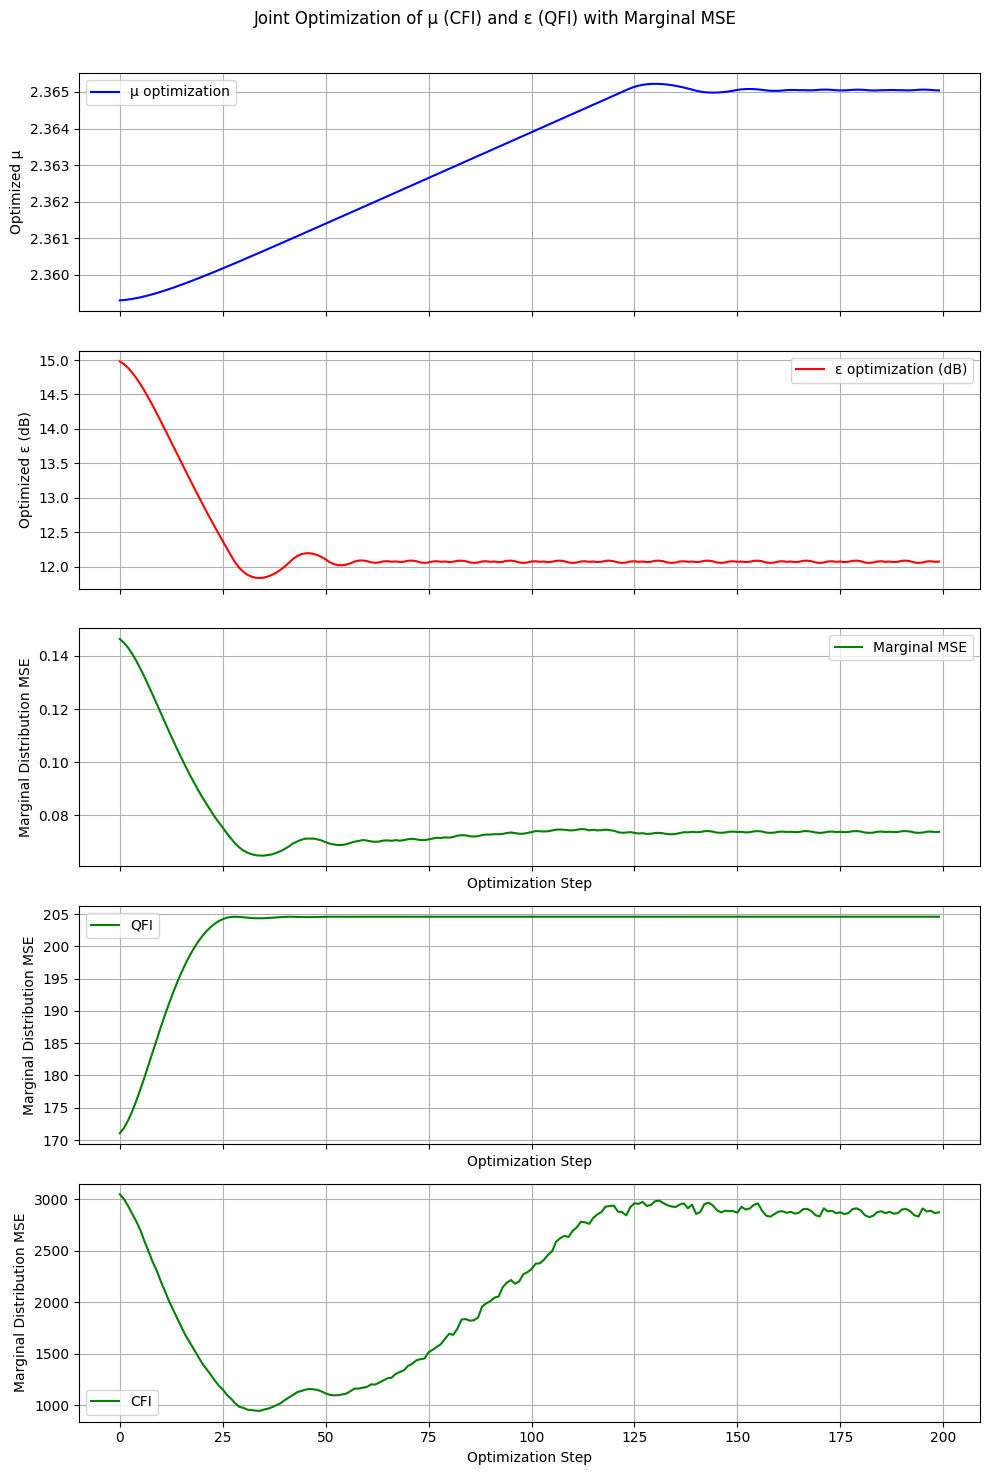

In [3]:
# --- Plot Results ---
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
# Plot μ history
axes[0].plot(mu_history, 'b-', markersize=3, label='μ optimization')
axes[0].set_ylabel('Optimized μ')
axes[0].legend()
axes[0].grid(True)

# Plot ε history
epsilon_db_history = [epsilon_to_db(ep) for ep in epsilon_history]
axes[1].plot(epsilon_db_history, 'r-', markersize=3, label='ε optimization (dB)')
axes[1].set_ylabel('Optimized ε (dB)')
axes[1].legend()
axes[1].grid(True)

# Plot marginal MSE
axes[2].plot(mse_history, 'g-', markersize=3, label='Marginal MSE')
axes[2].set_ylabel('Marginal Distribution MSE')
axes[2].set_xlabel('Optimization Step')
axes[2].legend()
axes[2].grid(True)

# Plot marginal MSE
axes[3].plot(qfi_history, 'g-', markersize=3, label='QFI')
axes[3].set_ylabel('Marginal Distribution MSE')
axes[3].set_xlabel('Optimization Step')
axes[3].legend()
axes[3].grid(True)

# Plot marginal MSE
axes[4].plot(cfi_history, 'g-', markersize=3, label='CFI')
axes[4].set_ylabel('Marginal Distribution MSE')
axes[4].set_xlabel('Optimization Step')
axes[4].legend()
axes[4].grid(True)

plt.suptitle('Joint Optimization of μ (CFI) and ε (QFI) with Marginal MSE')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [15]:
# --- File Paths ---
filename_path = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15_eta95_gamma2.txt"
data_to_save = np.column_stack((mu_history, epsilon_history, mse_history, qfi_history, cfi_history))

# Define header
header = "mu\t epsilon\t mse\t qfi\t cfi_det"

# Save to file
np.savetxt(filename_path, data_to_save, header=header, delimiter="\t", fmt='%.8e')

print("Optimization data saved")


Optimization data saved


In [29]:
import numpy as np

filename_path1 = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15.txt"
filename_path = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15_eta85_gamma3.txt"
filename_path = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15_eta95_gamma2.txt"


# Load the data; 'skiprows=1' to ignore the header line
loaded_data = np.loadtxt(filename_path, delimiter="\t", skiprows=1)

# Each column in 'loaded_data' corresponds to what you saved:
# mu_history, epsilon_history, mse_history, qfi_history, cfi_history
mu_loaded = loaded_data[:, 0]
epsilon_loaded = loaded_data[:, 1]
mse_loaded = loaded_data[:, 2]
qfi_loaded = loaded_data[:, 3]
cfi_loaded = loaded_data[:, 4]


# Plot CFI and QFI

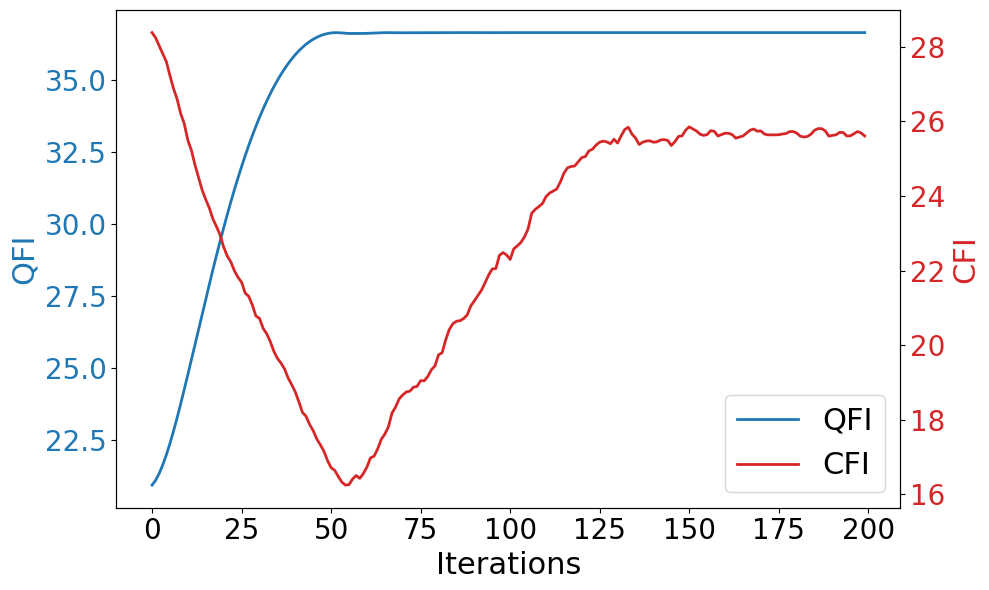

In [30]:
import matplotlib.pyplot as plt

steps_to_plot = 200  

fig, ax1 = plt.subplots(figsize=(10, 6))

color_qfi = 'tab:blue'
color_cfi = 'tab:red'

# Slice data to the first 70 steps
qfi_to_plot = qfi_history[:steps_to_plot]
cfi_to_plot = cfi_history[:steps_to_plot]

# Plot QFI on primary y-axis
ax1.set_xlabel('Iterations', fontsize=22)
ax1.set_ylabel('QFI', fontsize=22, color=color_qfi)
ax1.plot(range(steps_to_plot), qfi_to_plot, color=color_qfi, linewidth=2, label='QFI')
ax1.tick_params(axis='y', labelcolor=color_qfi, labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# Create secondary y-axis for squeezing
ax2 = ax1.twinx()
ax2.set_ylabel('CFI', fontsize=22, color=color_cfi)
ax2.plot(range(steps_to_plot), cfi_to_plot, 
         color=color_cfi, linewidth=2, label='CFI')
ax2.tick_params(axis='y', labelcolor=color_cfi, labelsize=20)

# ax1.grid(True)

# Legends (optional, recommended)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
lines_qfi, labels_qfi = ax1.get_legend_handles_labels()
lines_squeeze, labels_squeeze = ax2.get_legend_handles_labels()
ax1.legend(lines_qfi + lines_squeeze, labels_qfi + labels_squeeze, fontsize=22, loc='best')

plt.tight_layout()
plt.savefig('simul_QFI_CFI.png', dpi=1000)
plt.show()


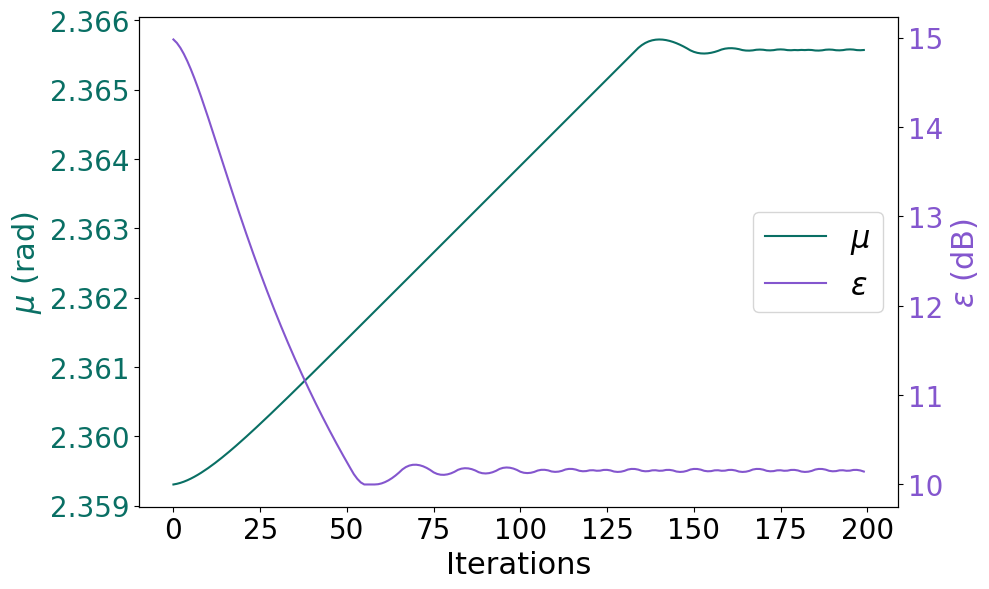

In [31]:
import matplotlib.pyplot as plt

to_plot = 200
# Convert epsilon to dB
epsilon_db_history = [epsilon_to_db(eps) for eps in epsilon_history[:to_plot]]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis (left) for Mu
color = '#096f64'
ax1.set_xlabel('Iterations', fontsize=22)
ax1.set_ylabel(f'$\mu$ (rad)', color=color, fontsize=22)
line1, = ax1.plot(mu_history[:to_plot], color=color, label=f'$\mu$')
ax1.tick_params(axis='y', labelcolor=color,  labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# Second axis (right) for Epsilon in dB
ax2 = ax1.twinx()
color = '#8456ce'
ax2.set_ylabel(f'$\epsilon$ (dB)', color=color, fontsize=22)
line2, = ax2.plot(epsilon_db_history, color=color, label=f'$\epsilon$')
ax2.tick_params(axis='y', labelcolor=color,  labelsize=20)


# Add legends clearly
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=22, loc='center right')

fig.tight_layout()

plt.savefig('simul_ep_mu.png', dpi=1000)
plt.show()


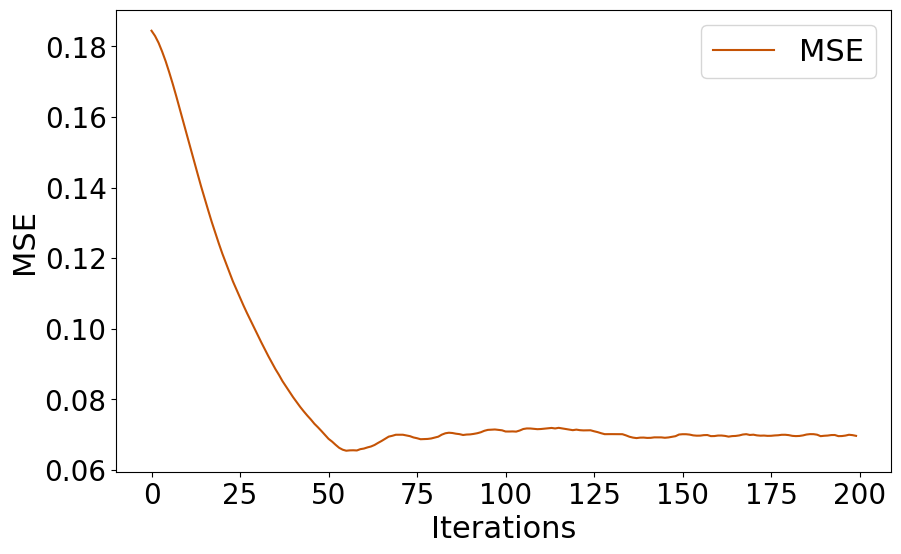

In [22]:
# --- Plot MSE vs. Iterations ---
to_plot = 200
fig2, ax2 = plt.subplots(figsize=(10, 6))

ax2.set_xlabel('Iterations', fontsize=22)
ax2.set_ylabel('MSE', fontsize=22)

# Plot MSE in a custom color (e.g., red)
line2, = ax2.plot(mse_loaded[:to_plot], color='#c55305', label='MSE')

ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)

# Pass the list of handles and labels to legend
ax2.legend([line2], ['MSE'], fontsize=22, loc='best')

plt.savefig('simul_MSE.png', dpi=1000)
plt.show()


In [16]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- CONFIGURATION ---
sf.hbar = 1

# Parameters
eta, delta = 0.85, 0.03
num_steps = 200
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)

learning_rate_mu = 0.0005
learning_rate_epsilon = 0.003


def db_to_epsilon(db_val):
    """Convert squeezing in dB to epsilon."""
    t = 10.0 ** (-db_val / 10.0)
    return 0.5 * np.log((1.0 + t) / (1.0 - t))

def epsilon_to_db(epsilon: float) -> float:
    """Convert epsilon to dB value"""
    t = np.tanh(epsilon)
    return -10.0 * np.log10(t)

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)
    return wigner_avg

def marginal_from_wigner(W, xvec, phi):
    """Compute marginal distribution from the Wigner function at angle phi."""
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]

    X = Q * np.cos(phi) + P * np.sin(phi)

    bin_indices = np.floor((X - xvec[0]) / dq).astype(int)
    valid_bins = (bin_indices >= 0) & (bin_indices < len(xvec))

    P_x_mu = np.bincount(bin_indices[valid_bins].ravel(),
                         weights=W[valid_bins].ravel() * dq**2,
                         minlength=len(xvec))

    norm = np.trapz(P_x_mu, xvec)
    if norm > 1e-15:
        P_x_mu /= norm
    return P_x_mu


def classical_fisher(mu, epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Calculate the 2x2 classical Fisher information matrix w.r.t. (eta, delta),
    given the homodyne measurement of quadrature x_mu.
    """
    # Base Wigner
    W_base = prepare_gkp_state(epsilon, eta, delta)
    P_mu = marginal_from_wigner(W_base, quad_axis, mu) + 1e-12

    # dP/d_eta
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta, delta)
    P_eta_plus = marginal_from_wigner(W_eta_plus, quad_axis, mu) + 1e-12
    dP_eta = (P_eta_plus - P_mu) / d_eta

    # dP/d_delta
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta)
    P_delta_plus = marginal_from_wigner(W_delta_plus, quad_axis, mu) + 1e-12
    dP_delta = (P_delta_plus - P_mu) / d_delta

    # Fisher matrix
    F_eta_eta = np.trapz((dP_eta**2) / P_mu, quad_axis)
    F_delta_delta = np.trapz((dP_delta**2) / P_mu, quad_axis)
    F_eta_delta = np.trapz((dP_eta * dP_delta) / P_mu, quad_axis)

    return np.array([[F_eta_eta, F_eta_delta],
                     [F_eta_delta, F_delta_delta]])

def fisher_det_mu(mu, epsilon, eta, delta):
    """To return det(F) for given mu."""
    F = classical_fisher(mu, epsilon, eta, delta)
    return np.linalg.det(F)

def compute_wigner_derivatives(epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Compute the derivatives of Wigner function with respect to eta and delta
    using central difference method
    """
    # Base Wigner function
    W_base = prepare_gkp_state(epsilon, eta, delta)
    
    # Compute dW/deta using central difference
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta/2, delta)
    W_eta_minus = prepare_gkp_state(epsilon, eta - d_eta/2, delta)
    dW_deta = (W_eta_plus - W_eta_minus) / d_eta
    
    # Compute dW/ddelta using central difference
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta/2)
    W_delta_minus = prepare_gkp_state(epsilon, eta, delta - d_delta/2)
    dW_ddelta = (W_delta_plus - W_delta_minus) / d_delta
    
    return W_base, dW_deta, dW_ddelta




# Additional helper function for marginal MSE calculation clearly:
def marginal_mse(epsilon, mu, eta, delta):
    W_ideal = prepare_gkp_state(epsilon, eta=1.0, gamma=0.0)
    W_noisy = prepare_gkp_state(epsilon, eta=eta, gamma=delta)

    P_ideal = marginal_from_wigner(W_ideal, quad_axis, phi=mu)
    P_noisy = marginal_from_wigner(W_noisy, quad_axis, phi=mu)

    mse = np.trapz((P_noisy - P_ideal)**2, quad_axis)
    return mse


def compute_qfi_bound(dW_deta, dW_ddelta):
    """
    Compute the QFI bound using Wigner function derivatives
    For multi-parameter case: F_total = F_eta_eta + F_delta_delta
    """
    dq = quad_axis[1] - quad_axis[0]
    dp = dq
    
    # Compute F_eta_eta ≤ 4π∫(∂_η W)² dq dp
    F_eta_eta = 4 * np.pi * np.sum(dW_deta**2) * dq * dp
    
    # Compute F_delta_delta ≤ 4π∫(∂_δ W)² dq dp
    F_delta_delta = 4 * np.pi * np.sum(dW_ddelta**2) * dq * dp
    
    # Total QFI (trace of QFI matrix)
    F_total = F_eta_eta + F_delta_delta
    
    return F_total, F_eta_eta, F_delta_delta

def compute_qfi_gradient(epsilon, eta, delta, d_epsilon=1e-3):
    """
    Compute the gradient of the QFI bound with respect to epsilon
    using central difference method
    """
    # Compute QFI at epsilon + d_epsilon/2
    _, dW_deta_plus, dW_ddelta_plus = compute_wigner_derivatives(
        epsilon + d_epsilon/2, eta, delta)
    F_total_plus, _, _ = compute_qfi_bound(dW_deta_plus, dW_ddelta_plus)
    
    # Compute QFI at epsilon - d_epsilon/2
    _, dW_deta_minus, dW_ddelta_minus = compute_wigner_derivatives(
        epsilon - d_epsilon/2, eta, delta)
    F_total_minus, _, _ = compute_qfi_bound(dW_deta_minus, dW_ddelta_minus)
    
    # Compute gradient
    grad_epsilon = (F_total_plus - F_total_minus) / d_epsilon
    
    return grad_epsilon



In [17]:
print(f"eta = {eta} and delta = {delta}")
# --- Initialization ---
epsilon = db_to_epsilon(15)
epsilon_min, epsilon_max = db_to_epsilon(16), db_to_epsilon(10)
mu = 2.3592999716910443  # initial mu

# History recording
epsilon_history, mu_history = [], []
mse_history = []
cfi_history, qfi_history = [], []

velocity_mu, velocity_epsilon = 0, 0
momentum = 0.9

# --- Joint Optimization Loop ---
for step in tqdm(range(num_steps)):
    # --- Compute gradient for mu via CFI ---
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    velocity_mu = momentum * velocity_mu + learning_rate_mu * grad_mu
    mu += velocity_mu
    mu %= (2 * np.pi)

    # --- Compute gradient for epsilon via QFI ---
    grad_epsilon = compute_qfi_gradient(epsilon, eta, delta)
    grad_epsilon = np.clip(grad_epsilon, -0.05, 0.05)

    velocity_epsilon = momentum * velocity_epsilon + learning_rate_epsilon * grad_epsilon
    epsilon += velocity_epsilon
    epsilon = np.clip(epsilon, epsilon_min, epsilon_max)

    # --- Evaluate Fisher information ---
    F_cfi = classical_fisher(mu, epsilon, eta, delta)
    det_F_cfi = np.linalg.det(F_cfi)
    cfi_history.append(det_F_cfi)

    _, dW_deta, dW_ddelta = compute_wigner_derivatives(epsilon, eta, delta)
    F_qfi, _, _ = compute_qfi_bound(dW_deta, dW_ddelta)
    qfi_history.append(F_qfi)

    # --- Marginal MSE ---
    mse = marginal_mse(epsilon, mu, eta, delta)
    mse_history.append(mse)

    epsilon_history.append(epsilon)
    mu_history.append(mu)

    if step % 1 == 0 or step == num_steps - 1:
        db_val = epsilon_to_db(epsilon)
        print(f"Step {step}: mu={mu:.4f}, ε={epsilon:.4f} ({db_val:.2f} dB), "
              f"CFI_det={det_F_cfi:.4e}, QFI={F_qfi:.4e}, MSE={mse:.4e}")


eta = 0.85 and delta = 0.03


  0%|          | 1/200 [12:55<42:53:12, 775.84s/it]

Step 0: mu=2.3593, ε=0.0318 (14.98 dB), CFI_det=2.8381e+01, QFI=2.0933e+01, MSE=1.8447e-01


  1%|          | 2/200 [25:47<42:32:34, 773.51s/it]

Step 1: mu=2.3593, ε=0.0321 (14.94 dB), CFI_det=2.8241e+01, QFI=2.1101e+01, MSE=1.8299e-01


  2%|▏         | 3/200 [38:33<42:08:16, 770.03s/it]

Step 2: mu=2.3593, ε=0.0325 (14.89 dB), CFI_det=2.8028e+01, QFI=2.1339e+01, MSE=1.8103e-01


  2%|▏         | 4/200 [51:11<41:39:26, 765.14s/it]

Step 3: mu=2.3593, ε=0.0330 (14.82 dB), CFI_det=2.7811e+01, QFI=2.1636e+01, MSE=1.7857e-01


  2%|▎         | 5/200 [1:03:40<41:08:13, 759.45s/it]

Step 4: mu=2.3594, ε=0.0336 (14.74 dB), CFI_det=2.7599e+01, QFI=2.1986e+01, MSE=1.7581e-01


  3%|▎         | 6/200 [1:15:59<40:32:32, 752.33s/it]

Step 5: mu=2.3594, ε=0.0343 (14.65 dB), CFI_det=2.7230e+01, QFI=2.2380e+01, MSE=1.7270e-01


  4%|▎         | 7/200 [1:28:04<39:51:27, 743.46s/it]

Step 6: mu=2.3594, ε=0.0351 (14.55 dB), CFI_det=2.6882e+01, QFI=2.2810e+01, MSE=1.6939e-01


  4%|▍         | 8/200 [1:39:57<39:08:29, 733.90s/it]

Step 7: mu=2.3594, ε=0.0359 (14.45 dB), CFI_det=2.6599e+01, QFI=2.3271e+01, MSE=1.6588e-01


  4%|▍         | 9/200 [1:51:39<38:23:51, 723.72s/it]

Step 8: mu=2.3595, ε=0.0369 (14.34 dB), CFI_det=2.6210e+01, QFI=2.3755e+01, MSE=1.6226e-01


  5%|▌         | 10/200 [2:03:08<37:38:23, 713.17s/it]

Step 9: mu=2.3595, ε=0.0378 (14.22 dB), CFI_det=2.5939e+01, QFI=2.4256e+01, MSE=1.5861e-01


  6%|▌         | 11/200 [2:14:26<36:52:06, 702.26s/it]

Step 10: mu=2.3595, ε=0.0389 (14.11 dB), CFI_det=2.5494e+01, QFI=2.4771e+01, MSE=1.5491e-01


  6%|▌         | 12/200 [2:25:28<36:02:15, 690.08s/it]

Step 11: mu=2.3596, ε=0.0399 (13.99 dB), CFI_det=2.5223e+01, QFI=2.5295e+01, MSE=1.5124e-01


  6%|▋         | 13/200 [2:36:17<35:12:12, 677.71s/it]

Step 12: mu=2.3596, ε=0.0411 (13.87 dB), CFI_det=2.4832e+01, QFI=2.5823e+01, MSE=1.4753e-01


  7%|▋         | 14/200 [2:46:59<34:27:21, 666.89s/it]

Step 13: mu=2.3597, ε=0.0422 (13.75 dB), CFI_det=2.4497e+01, QFI=2.6353e+01, MSE=1.4397e-01


  8%|▊         | 15/200 [2:57:27<33:40:15, 655.22s/it]

Step 14: mu=2.3597, ε=0.0434 (13.63 dB), CFI_det=2.4158e+01, QFI=2.6880e+01, MSE=1.4038e-01


  8%|▊         | 16/200 [3:07:44<32:53:46, 643.62s/it]

Step 15: mu=2.3597, ε=0.0446 (13.51 dB), CFI_det=2.3904e+01, QFI=2.7402e+01, MSE=1.3694e-01


  8%|▊         | 17/200 [3:17:45<32:03:44, 630.73s/it]

Step 16: mu=2.3598, ε=0.0459 (13.39 dB), CFI_det=2.3679e+01, QFI=2.7918e+01, MSE=1.3361e-01


  9%|▉         | 18/200 [3:27:34<31:15:45, 618.38s/it]

Step 17: mu=2.3598, ε=0.0472 (13.27 dB), CFI_det=2.3382e+01, QFI=2.8425e+01, MSE=1.3031e-01


 10%|▉         | 19/200 [3:37:15<30:31:40, 607.18s/it]

Step 18: mu=2.3599, ε=0.0485 (13.15 dB), CFI_det=2.3181e+01, QFI=2.8921e+01, MSE=1.2723e-01


 10%|█         | 20/200 [3:46:43<29:46:10, 595.39s/it]

Step 19: mu=2.3599, ε=0.0498 (13.03 dB), CFI_det=2.2956e+01, QFI=2.9404e+01, MSE=1.2420e-01


 10%|█         | 21/200 [3:56:00<29:01:30, 583.74s/it]

Step 20: mu=2.3599, ε=0.0511 (12.92 dB), CFI_det=2.2631e+01, QFI=2.9875e+01, MSE=1.2132e-01


 11%|█         | 22/200 [4:05:04<28:16:20, 571.80s/it]

Step 21: mu=2.3600, ε=0.0525 (12.81 dB), CFI_det=2.2389e+01, QFI=3.0331e+01, MSE=1.1865e-01


 12%|█▏        | 23/200 [4:13:56<27:31:28, 559.82s/it]

Step 22: mu=2.3600, ε=0.0538 (12.69 dB), CFI_det=2.2235e+01, QFI=3.0772e+01, MSE=1.1604e-01


 12%|█▏        | 24/200 [4:22:40<26:50:38, 549.08s/it]

Step 23: mu=2.3601, ε=0.0552 (12.58 dB), CFI_det=2.1996e+01, QFI=3.1197e+01, MSE=1.1341e-01


 12%|█▎        | 25/200 [4:31:13<26:10:33, 538.47s/it]

Step 24: mu=2.3601, ε=0.0566 (12.48 dB), CFI_det=2.1821e+01, QFI=3.1606e+01, MSE=1.1112e-01


 13%|█▎        | 26/200 [4:39:37<25:30:59, 527.93s/it]

Step 25: mu=2.3602, ε=0.0580 (12.37 dB), CFI_det=2.1690e+01, QFI=3.1999e+01, MSE=1.0884e-01


 14%|█▎        | 27/200 [4:47:52<24:54:14, 518.23s/it]

Step 26: mu=2.3602, ε=0.0594 (12.27 dB), CFI_det=2.1399e+01, QFI=3.2374e+01, MSE=1.0655e-01


 14%|█▍        | 28/200 [4:55:56<24:15:29, 507.73s/it]

Step 27: mu=2.3603, ε=0.0608 (12.16 dB), CFI_det=2.1310e+01, QFI=3.2733e+01, MSE=1.0439e-01


 14%|█▍        | 29/200 [5:03:45<23:34:25, 496.29s/it]

Step 28: mu=2.3603, ε=0.0623 (12.06 dB), CFI_det=2.1080e+01, QFI=3.3075e+01, MSE=1.0232e-01


 15%|█▌        | 30/200 [5:11:29<22:58:41, 486.60s/it]

Step 29: mu=2.3604, ε=0.0637 (11.96 dB), CFI_det=2.0783e+01, QFI=3.3399e+01, MSE=1.0022e-01


 16%|█▌        | 31/200 [5:19:04<22:23:28, 476.98s/it]

Step 30: mu=2.3604, ε=0.0651 (11.87 dB), CFI_det=2.0721e+01, QFI=3.3707e+01, MSE=9.8146e-02


 16%|█▌        | 32/200 [5:26:28<21:48:08, 467.19s/it]

Step 31: mu=2.3605, ε=0.0666 (11.77 dB), CFI_det=2.0456e+01, QFI=3.3997e+01, MSE=9.6170e-02


 16%|█▋        | 33/200 [5:33:46<21:15:39, 458.32s/it]

Step 32: mu=2.3605, ε=0.0681 (11.68 dB), CFI_det=2.0309e+01, QFI=3.4271e+01, MSE=9.4184e-02


 17%|█▋        | 34/200 [5:40:57<20:45:37, 450.23s/it]

Step 33: mu=2.3606, ε=0.0695 (11.59 dB), CFI_det=2.0102e+01, QFI=3.4528e+01, MSE=9.2241e-02


 18%|█▊        | 35/200 [5:48:00<20:15:27, 441.98s/it]

Step 34: mu=2.3606, ε=0.0710 (11.50 dB), CFI_det=1.9838e+01, QFI=3.4769e+01, MSE=9.0425e-02


 18%|█▊        | 36/200 [5:54:53<19:44:13, 433.25s/it]

Step 35: mu=2.3607, ε=0.0724 (11.41 dB), CFI_det=1.9647e+01, QFI=3.4994e+01, MSE=8.8564e-02


 18%|█▊        | 37/200 [6:01:33<19:10:18, 423.43s/it]

Step 36: mu=2.3607, ε=0.0739 (11.32 dB), CFI_det=1.9522e+01, QFI=3.5203e+01, MSE=8.6927e-02


 19%|█▉        | 38/200 [6:08:05<18:37:38, 413.94s/it]

Step 37: mu=2.3608, ε=0.0754 (11.24 dB), CFI_det=1.9364e+01, QFI=3.5396e+01, MSE=8.5143e-02


 20%|█▉        | 39/200 [6:14:31<18:08:36, 405.69s/it]

Step 38: mu=2.3608, ε=0.0769 (11.15 dB), CFI_det=1.9122e+01, QFI=3.5574e+01, MSE=8.3618e-02


 20%|██        | 40/200 [6:20:51<17:40:44, 397.78s/it]

Step 39: mu=2.3609, ε=0.0783 (11.07 dB), CFI_det=1.8941e+01, QFI=3.5738e+01, MSE=8.2066e-02


 20%|██        | 41/200 [6:27:04<17:14:24, 390.34s/it]

Step 40: mu=2.3609, ε=0.0798 (10.99 dB), CFI_det=1.8747e+01, QFI=3.5887e+01, MSE=8.0600e-02


 21%|██        | 42/200 [6:33:10<16:48:54, 383.13s/it]

Step 41: mu=2.3610, ε=0.0813 (10.91 dB), CFI_det=1.8483e+01, QFI=3.6021e+01, MSE=7.9213e-02


 22%|██▏       | 43/200 [6:39:12<16:25:54, 376.78s/it]

Step 42: mu=2.3610, ε=0.0828 (10.83 dB), CFI_det=1.8197e+01, QFI=3.6142e+01, MSE=7.7847e-02


 22%|██▏       | 44/200 [6:45:05<16:01:14, 369.71s/it]

Step 43: mu=2.3611, ε=0.0843 (10.75 dB), CFI_det=1.8095e+01, QFI=3.6249e+01, MSE=7.6590e-02


 22%|██▎       | 45/200 [6:50:50<15:36:00, 362.32s/it]

Step 44: mu=2.3611, ε=0.0858 (10.68 dB), CFI_det=1.7875e+01, QFI=3.6342e+01, MSE=7.5400e-02


 23%|██▎       | 46/200 [6:56:30<15:12:48, 355.64s/it]

Step 45: mu=2.3612, ε=0.0872 (10.60 dB), CFI_det=1.7709e+01, QFI=3.6423e+01, MSE=7.4297e-02


 24%|██▎       | 47/200 [7:02:02<14:48:17, 348.35s/it]

Step 46: mu=2.3612, ε=0.0887 (10.53 dB), CFI_det=1.7486e+01, QFI=3.6491e+01, MSE=7.3082e-02


 24%|██▍       | 48/200 [7:07:23<14:21:46, 340.17s/it]

Step 47: mu=2.3613, ε=0.0902 (10.46 dB), CFI_det=1.7330e+01, QFI=3.6547e+01, MSE=7.2083e-02


 24%|██▍       | 49/200 [7:12:38<13:57:31, 332.79s/it]

Step 48: mu=2.3613, ε=0.0917 (10.39 dB), CFI_det=1.7156e+01, QFI=3.6590e+01, MSE=7.1020e-02


 25%|██▌       | 50/200 [7:17:51<13:36:36, 326.64s/it]

Step 49: mu=2.3614, ε=0.0932 (10.32 dB), CFI_det=1.6908e+01, QFI=3.6622e+01, MSE=6.9894e-02


 26%|██▌       | 51/200 [7:22:58<13:16:41, 320.82s/it]

Step 50: mu=2.3614, ε=0.0947 (10.25 dB), CFI_det=1.6714e+01, QFI=3.6643e+01, MSE=6.8805e-02


 26%|██▌       | 52/200 [7:28:03<12:59:37, 316.06s/it]

Step 51: mu=2.3615, ε=0.0962 (10.18 dB), CFI_det=1.6648e+01, QFI=3.6653e+01, MSE=6.8025e-02


 26%|██▋       | 53/200 [7:33:01<12:41:15, 310.72s/it]

Step 52: mu=2.3615, ε=0.0977 (10.12 dB), CFI_det=1.6480e+01, QFI=3.6652e+01, MSE=6.7107e-02


 27%|██▋       | 54/200 [7:37:54<12:23:19, 305.48s/it]

Step 53: mu=2.3616, ε=0.0989 (10.06 dB), CFI_det=1.6330e+01, QFI=3.6643e+01, MSE=6.6260e-02


 28%|██▊       | 55/200 [7:42:42<12:05:01, 300.01s/it]

Step 54: mu=2.3616, ε=0.0998 (10.02 dB), CFI_det=1.6249e+01, QFI=3.6632e+01, MSE=6.5725e-02


 28%|██▊       | 56/200 [7:47:26<11:48:37, 295.26s/it]

Step 55: mu=2.3617, ε=0.1003 (10.00 dB), CFI_det=1.6263e+01, QFI=3.6624e+01, MSE=6.5434e-02


 28%|██▊       | 57/200 [7:52:08<11:34:38, 291.45s/it]

Step 56: mu=2.3617, ε=0.1003 (10.00 dB), CFI_det=1.6412e+01, QFI=3.6624e+01, MSE=6.5535e-02


 29%|██▉       | 58/200 [7:56:52<11:24:03, 289.04s/it]

Step 57: mu=2.3618, ε=0.1003 (10.00 dB), CFI_det=1.6507e+01, QFI=3.6624e+01, MSE=6.5559e-02


 30%|██▉       | 59/200 [8:01:35<11:15:20, 287.38s/it]

Step 58: mu=2.3618, ε=0.1003 (10.00 dB), CFI_det=1.6429e+01, QFI=3.6624e+01, MSE=6.5507e-02


 30%|███       | 60/200 [8:06:19<11:07:42, 286.16s/it]

Step 59: mu=2.3619, ε=0.1003 (10.00 dB), CFI_det=1.6558e+01, QFI=3.6625e+01, MSE=6.5879e-02


 30%|███       | 61/200 [8:11:01<11:00:10, 284.96s/it]

Step 60: mu=2.3619, ε=0.1001 (10.01 dB), CFI_det=1.6734e+01, QFI=3.6629e+01, MSE=6.6049e-02


 31%|███       | 62/200 [8:15:44<10:54:30, 284.57s/it]

Step 61: mu=2.3620, ε=0.0997 (10.03 dB), CFI_det=1.6979e+01, QFI=3.6634e+01, MSE=6.6372e-02


 32%|███▏      | 63/200 [8:20:28<10:49:15, 284.35s/it]

Step 62: mu=2.3620, ε=0.0993 (10.05 dB), CFI_det=1.7025e+01, QFI=3.6639e+01, MSE=6.6635e-02


 32%|███▏      | 64/200 [8:25:16<10:46:43, 285.32s/it]

Step 63: mu=2.3621, ε=0.0987 (10.07 dB), CFI_det=1.7218e+01, QFI=3.6645e+01, MSE=6.7062e-02


 32%|███▎      | 65/200 [8:30:04<10:44:09, 286.29s/it]

Step 64: mu=2.3621, ε=0.0980 (10.10 dB), CFI_det=1.7475e+01, QFI=3.6650e+01, MSE=6.7656e-02


 33%|███▎      | 66/200 [8:34:58<10:44:02, 288.38s/it]

Step 65: mu=2.3622, ε=0.0973 (10.13 dB), CFI_det=1.7617e+01, QFI=3.6653e+01, MSE=6.8207e-02


 34%|███▎      | 67/200 [8:39:54<10:44:49, 290.90s/it]

Step 66: mu=2.3622, ε=0.0965 (10.17 dB), CFI_det=1.7811e+01, QFI=3.6654e+01, MSE=6.8817e-02


 34%|███▍      | 68/200 [8:44:55<10:46:20, 293.79s/it]

Step 67: mu=2.3623, ε=0.0959 (10.19 dB), CFI_det=1.8180e+01, QFI=3.6652e+01, MSE=6.9431e-02


 34%|███▍      | 69/200 [8:49:57<10:46:44, 296.21s/it]

Step 68: mu=2.3623, ε=0.0955 (10.21 dB), CFI_det=1.8342e+01, QFI=3.6650e+01, MSE=6.9665e-02


 35%|███▌      | 70/200 [8:55:00<10:46:15, 298.27s/it]

Step 69: mu=2.3624, ε=0.0953 (10.22 dB), CFI_det=1.8561e+01, QFI=3.6649e+01, MSE=6.9961e-02


 36%|███▌      | 71/200 [9:00:03<10:44:07, 299.59s/it]

Step 70: mu=2.3624, ε=0.0953 (10.22 dB), CFI_det=1.8666e+01, QFI=3.6649e+01, MSE=6.9950e-02


 36%|███▌      | 72/200 [9:05:05<10:41:03, 300.50s/it]

Step 71: mu=2.3625, ε=0.0955 (10.21 dB), CFI_det=1.8747e+01, QFI=3.6650e+01, MSE=6.9965e-02


 36%|███▋      | 73/200 [9:10:06<10:36:30, 300.71s/it]

Step 72: mu=2.3625, ε=0.0957 (10.20 dB), CFI_det=1.8768e+01, QFI=3.6651e+01, MSE=6.9756e-02


 37%|███▋      | 74/200 [9:15:08<10:32:01, 300.96s/it]

Step 73: mu=2.3626, ε=0.0961 (10.19 dB), CFI_det=1.8874e+01, QFI=3.6653e+01, MSE=6.9562e-02


 38%|███▊      | 75/200 [9:20:09<10:27:05, 301.00s/it]

Step 74: mu=2.3626, ε=0.0966 (10.16 dB), CFI_det=1.8895e+01, QFI=3.6654e+01, MSE=6.9195e-02


 38%|███▊      | 76/200 [9:25:07<10:20:18, 300.15s/it]

Step 75: mu=2.3627, ε=0.0972 (10.14 dB), CFI_det=1.9049e+01, QFI=3.6653e+01, MSE=6.8976e-02


 38%|███▊      | 77/200 [9:30:03<10:12:28, 298.77s/it]

Step 76: mu=2.3627, ε=0.0976 (10.12 dB), CFI_det=1.9046e+01, QFI=3.6652e+01, MSE=6.8693e-02


 39%|███▉      | 78/200 [9:34:57<10:04:51, 297.47s/it]

Step 77: mu=2.3628, ε=0.0978 (10.11 dB), CFI_det=1.9161e+01, QFI=3.6651e+01, MSE=6.8733e-02


 40%|███▉      | 79/200 [9:39:50<9:57:20, 296.21s/it] 

Step 78: mu=2.3628, ε=0.0979 (10.11 dB), CFI_det=1.9343e+01, QFI=3.6651e+01, MSE=6.8775e-02


 40%|████      | 80/200 [9:44:45<9:51:21, 295.68s/it]

Step 79: mu=2.3629, ε=0.0977 (10.11 dB), CFI_det=1.9445e+01, QFI=3.6652e+01, MSE=6.8906e-02


 40%|████      | 81/200 [9:49:39<9:45:46, 295.35s/it]

Step 80: mu=2.3629, ε=0.0975 (10.12 dB), CFI_det=1.9743e+01, QFI=3.6653e+01, MSE=6.9155e-02


 41%|████      | 82/200 [9:54:36<9:41:41, 295.78s/it]

Step 81: mu=2.3630, ε=0.0971 (10.14 dB), CFI_det=1.9798e+01, QFI=3.6653e+01, MSE=6.9416e-02


 42%|████▏     | 83/200 [9:59:35<9:38:30, 296.67s/it]

Step 82: mu=2.3630, ε=0.0966 (10.16 dB), CFI_det=2.0143e+01, QFI=3.6654e+01, MSE=6.9994e-02


 42%|████▏     | 84/200 [10:04:35<9:35:25, 297.64s/it]

Step 83: mu=2.3631, ε=0.0963 (10.18 dB), CFI_det=2.0422e+01, QFI=3.6653e+01, MSE=7.0376e-02


 42%|████▎     | 85/200 [10:09:34<9:31:23, 298.11s/it]

Step 84: mu=2.3631, ε=0.0962 (10.18 dB), CFI_det=2.0575e+01, QFI=3.6653e+01, MSE=7.0534e-02


 43%|████▎     | 86/200 [10:14:34<9:27:26, 298.66s/it]

Step 85: mu=2.3632, ε=0.0962 (10.18 dB), CFI_det=2.0642e+01, QFI=3.6653e+01, MSE=7.0451e-02


 44%|████▎     | 87/200 [10:19:34<9:23:21, 299.13s/it]

Step 86: mu=2.3632, ε=0.0964 (10.17 dB), CFI_det=2.0658e+01, QFI=3.6653e+01, MSE=7.0258e-02


 44%|████▍     | 88/200 [10:24:32<9:17:45, 298.80s/it]

Step 87: mu=2.3633, ε=0.0968 (10.16 dB), CFI_det=2.0716e+01, QFI=3.6654e+01, MSE=7.0133e-02


 44%|████▍     | 89/200 [10:29:29<9:11:23, 298.05s/it]

Step 88: mu=2.3633, ε=0.0972 (10.14 dB), CFI_det=2.0811e+01, QFI=3.6653e+01, MSE=6.9891e-02


 45%|████▌     | 90/200 [10:34:25<9:05:20, 297.46s/it]

Step 89: mu=2.3634, ε=0.0974 (10.13 dB), CFI_det=2.1052e+01, QFI=3.6653e+01, MSE=7.0018e-02


 46%|████▌     | 91/200 [10:39:20<8:59:13, 296.82s/it]

Step 90: mu=2.3634, ε=0.0975 (10.12 dB), CFI_det=2.1188e+01, QFI=3.6652e+01, MSE=7.0060e-02


 46%|████▌     | 92/200 [10:44:16<8:53:47, 296.55s/it]

Step 91: mu=2.3634, ε=0.0974 (10.13 dB), CFI_det=2.1335e+01, QFI=3.6653e+01, MSE=7.0203e-02


 46%|████▋     | 93/200 [10:49:14<8:49:29, 296.91s/it]

Step 92: mu=2.3635, ε=0.0972 (10.14 dB), CFI_det=2.1474e+01, QFI=3.6653e+01, MSE=7.0390e-02


 47%|████▋     | 94/200 [10:59:11<11:23:55, 387.13s/it]

Step 93: mu=2.3635, ε=0.0968 (10.15 dB), CFI_det=2.1675e+01, QFI=3.6654e+01, MSE=7.0663e-02


 48%|████▊     | 95/200 [11:08:36<12:50:47, 440.45s/it]

Step 94: mu=2.3636, ε=0.0964 (10.17 dB), CFI_det=2.1882e+01, QFI=3.6653e+01, MSE=7.1079e-02


 48%|████▊     | 96/200 [11:18:05<13:49:56, 478.82s/it]

Step 95: mu=2.3636, ε=0.0961 (10.19 dB), CFI_det=2.2045e+01, QFI=3.6653e+01, MSE=7.1341e-02


 48%|████▊     | 97/200 [11:27:46<14:34:54, 509.66s/it]

Step 96: mu=2.3637, ε=0.0960 (10.19 dB), CFI_det=2.2055e+01, QFI=3.6652e+01, MSE=7.1413e-02


 49%|████▉     | 98/200 [11:37:26<15:02:08, 530.67s/it]

Step 97: mu=2.3637, ε=0.0961 (10.19 dB), CFI_det=2.2410e+01, QFI=3.6653e+01, MSE=7.1455e-02


 50%|████▉     | 99/200 [11:46:56<15:13:25, 542.63s/it]

Step 98: mu=2.3638, ε=0.0963 (10.18 dB), CFI_det=2.2483e+01, QFI=3.6653e+01, MSE=7.1328e-02


 50%|█████     | 100/200 [11:56:20<15:14:56, 548.96s/it]

Step 99: mu=2.3638, ε=0.0966 (10.16 dB), CFI_det=2.2421e+01, QFI=3.6654e+01, MSE=7.1222e-02


 50%|█████     | 101/200 [12:05:43<15:12:53, 553.27s/it]

Step 100: mu=2.3639, ε=0.0971 (10.14 dB), CFI_det=2.2298e+01, QFI=3.6654e+01, MSE=7.0883e-02


 51%|█████     | 102/200 [12:15:01<15:05:59, 554.69s/it]

Step 101: mu=2.3639, ε=0.0973 (10.13 dB), CFI_det=2.2585e+01, QFI=3.6653e+01, MSE=7.0876e-02


 52%|█████▏    | 103/200 [12:24:08<14:52:34, 552.11s/it]

Step 102: mu=2.3640, ε=0.0974 (10.13 dB), CFI_det=2.2663e+01, QFI=3.6653e+01, MSE=7.0905e-02


 52%|█████▏    | 104/200 [12:33:32<14:49:06, 555.69s/it]

Step 103: mu=2.3640, ε=0.0973 (10.13 dB), CFI_det=2.2755e+01, QFI=3.6653e+01, MSE=7.0851e-02


 52%|█████▎    | 105/200 [12:42:40<14:36:36, 553.65s/it]

Step 104: mu=2.3641, ε=0.0971 (10.14 dB), CFI_det=2.2905e+01, QFI=3.6653e+01, MSE=7.1159e-02


 53%|█████▎    | 106/200 [12:51:52<14:26:24, 553.03s/it]

Step 105: mu=2.3641, ε=0.0968 (10.16 dB), CFI_det=2.3118e+01, QFI=3.6654e+01, MSE=7.1586e-02


 54%|█████▎    | 107/200 [13:01:09<14:19:14, 554.35s/it]

Step 106: mu=2.3642, ε=0.0966 (10.16 dB), CFI_det=2.3535e+01, QFI=3.6654e+01, MSE=7.1747e-02


 54%|█████▍    | 108/200 [13:10:56<14:24:45, 563.97s/it]

Step 107: mu=2.3642, ε=0.0966 (10.16 dB), CFI_det=2.3642e+01, QFI=3.6654e+01, MSE=7.1736e-02


 55%|█████▍    | 109/200 [13:20:14<14:12:38, 562.19s/it]

Step 108: mu=2.3643, ε=0.0967 (10.16 dB), CFI_det=2.3715e+01, QFI=3.6654e+01, MSE=7.1644e-02


 55%|█████▌    | 110/200 [13:29:39<14:04:46, 563.19s/it]

Step 109: mu=2.3643, ε=0.0970 (10.15 dB), CFI_det=2.3795e+01, QFI=3.6654e+01, MSE=7.1539e-02


 56%|█████▌    | 111/200 [13:39:04<13:56:12, 563.74s/it]

Step 110: mu=2.3644, ε=0.0971 (10.14 dB), CFI_det=2.3983e+01, QFI=3.6653e+01, MSE=7.1587e-02


 56%|█████▌    | 112/200 [13:48:23<13:44:36, 562.23s/it]

Step 111: mu=2.3644, ε=0.0970 (10.14 dB), CFI_det=2.4079e+01, QFI=3.6654e+01, MSE=7.1697e-02


 56%|█████▋    | 113/200 [13:57:44<13:34:29, 561.71s/it]

Step 112: mu=2.3645, ε=0.0968 (10.15 dB), CFI_det=2.4132e+01, QFI=3.6654e+01, MSE=7.1811e-02


 57%|█████▋    | 114/200 [14:07:01<13:23:07, 560.32s/it]

Step 113: mu=2.3645, ε=0.0965 (10.17 dB), CFI_det=2.4187e+01, QFI=3.6654e+01, MSE=7.1891e-02


 57%|█████▊    | 115/200 [14:16:22<13:14:03, 560.51s/it]

Step 114: mu=2.3646, ε=0.0964 (10.17 dB), CFI_det=2.4373e+01, QFI=3.6653e+01, MSE=7.1744e-02


 58%|█████▊    | 116/200 [14:25:48<13:06:56, 562.11s/it]

Step 115: mu=2.3646, ε=0.0964 (10.17 dB), CFI_det=2.4612e+01, QFI=3.6653e+01, MSE=7.1918e-02


 58%|█████▊    | 117/200 [14:35:10<12:57:43, 562.21s/it]

Step 116: mu=2.3647, ε=0.0965 (10.17 dB), CFI_det=2.4756e+01, QFI=3.6654e+01, MSE=7.1747e-02


 59%|█████▉    | 118/200 [14:44:30<12:47:22, 561.49s/it]

Step 117: mu=2.3647, ε=0.0968 (10.15 dB), CFI_det=2.4791e+01, QFI=3.6654e+01, MSE=7.1570e-02


 60%|█████▉    | 119/200 [14:53:46<12:35:48, 559.86s/it]

Step 118: mu=2.3648, ε=0.0970 (10.15 dB), CFI_det=2.4805e+01, QFI=3.6654e+01, MSE=7.1377e-02


 60%|██████    | 120/200 [15:03:04<12:25:40, 559.25s/it]

Step 119: mu=2.3648, ε=0.0969 (10.15 dB), CFI_det=2.4917e+01, QFI=3.6654e+01, MSE=7.1259e-02


 60%|██████    | 121/200 [15:12:16<12:13:36, 557.17s/it]

Step 120: mu=2.3649, ε=0.0967 (10.16 dB), CFI_det=2.5031e+01, QFI=3.6654e+01, MSE=7.1414e-02


 61%|██████    | 122/200 [15:21:38<12:06:12, 558.62s/it]

Step 121: mu=2.3649, ε=0.0967 (10.16 dB), CFI_det=2.5059e+01, QFI=3.6654e+01, MSE=7.1256e-02


 62%|██████▏   | 123/200 [15:30:58<11:57:17, 558.93s/it]

Step 122: mu=2.3650, ε=0.0968 (10.15 dB), CFI_det=2.5212e+01, QFI=3.6654e+01, MSE=7.1195e-02


 62%|██████▏   | 124/200 [15:40:32<11:53:55, 563.62s/it]

Step 123: mu=2.3650, ε=0.0968 (10.15 dB), CFI_det=2.5256e+01, QFI=3.6654e+01, MSE=7.1201e-02


 62%|██████▎   | 125/200 [15:49:59<11:45:39, 564.53s/it]

Step 124: mu=2.3651, ε=0.0966 (10.16 dB), CFI_det=2.5368e+01, QFI=3.6654e+01, MSE=7.1229e-02


 63%|██████▎   | 126/200 [15:59:22<11:35:41, 564.08s/it]

Step 125: mu=2.3651, ε=0.0966 (10.16 dB), CFI_det=2.5444e+01, QFI=3.6654e+01, MSE=7.0949e-02


 64%|██████▎   | 127/200 [16:08:43<11:25:21, 563.30s/it]

Step 126: mu=2.3652, ε=0.0967 (10.16 dB), CFI_det=2.5472e+01, QFI=3.6654e+01, MSE=7.0709e-02


 64%|██████▍   | 128/200 [16:18:02<11:14:17, 561.91s/it]

Step 127: mu=2.3652, ε=0.0970 (10.14 dB), CFI_det=2.5450e+01, QFI=3.6654e+01, MSE=7.0394e-02


 64%|██████▍   | 129/200 [16:27:22<11:04:20, 561.42s/it]

Step 128: mu=2.3653, ε=0.0971 (10.14 dB), CFI_det=2.5403e+01, QFI=3.6653e+01, MSE=7.0126e-02


 65%|██████▌   | 130/200 [16:36:35<10:51:47, 558.68s/it]

Step 129: mu=2.3653, ε=0.0971 (10.14 dB), CFI_det=2.5522e+01, QFI=3.6654e+01, MSE=7.0145e-02


 66%|██████▌   | 131/200 [16:45:52<10:41:53, 558.17s/it]

Step 130: mu=2.3654, ε=0.0969 (10.15 dB), CFI_det=2.5419e+01, QFI=3.6654e+01, MSE=7.0138e-02


 66%|██████▌   | 132/200 [16:55:06<10:31:20, 557.07s/it]

Step 131: mu=2.3654, ε=0.0965 (10.17 dB), CFI_det=2.5614e+01, QFI=3.6654e+01, MSE=7.0140e-02


 66%|██████▋   | 133/200 [17:04:24<10:22:15, 557.24s/it]

Step 132: mu=2.3655, ε=0.0964 (10.17 dB), CFI_det=2.5785e+01, QFI=3.6653e+01, MSE=7.0171e-02


 67%|██████▋   | 134/200 [17:13:45<10:14:14, 558.41s/it]

Step 133: mu=2.3655, ε=0.0964 (10.17 dB), CFI_det=2.5843e+01, QFI=3.6653e+01, MSE=7.0117e-02


 68%|██████▊   | 135/200 [17:23:10<10:07:04, 560.38s/it]

Step 134: mu=2.3656, ε=0.0965 (10.17 dB), CFI_det=2.5661e+01, QFI=3.6654e+01, MSE=6.9787e-02


 68%|██████▊   | 136/200 [17:32:35<9:59:13, 561.78s/it] 

Step 135: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5557e+01, QFI=3.6654e+01, MSE=6.9396e-02


 68%|██████▊   | 137/200 [17:41:56<9:49:46, 561.68s/it]

Step 136: mu=2.3657, ε=0.0970 (10.15 dB), CFI_det=2.5382e+01, QFI=3.6654e+01, MSE=6.9150e-02


 69%|██████▉   | 138/200 [17:51:18<9:40:28, 561.74s/it]

Step 137: mu=2.3657, ε=0.0969 (10.15 dB), CFI_det=2.5443e+01, QFI=3.6654e+01, MSE=6.9011e-02


 70%|██████▉   | 139/200 [18:00:36<9:30:00, 560.67s/it]

Step 138: mu=2.3657, ε=0.0967 (10.16 dB), CFI_det=2.5475e+01, QFI=3.6654e+01, MSE=6.9145e-02


 70%|███████   | 140/200 [18:09:58<9:20:52, 560.87s/it]

Step 139: mu=2.3657, ε=0.0967 (10.16 dB), CFI_det=2.5481e+01, QFI=3.6654e+01, MSE=6.9160e-02


 70%|███████   | 141/200 [18:19:06<9:07:43, 557.02s/it]

Step 140: mu=2.3657, ε=0.0968 (10.15 dB), CFI_det=2.5443e+01, QFI=3.6654e+01, MSE=6.9066e-02


 71%|███████   | 142/200 [18:28:13<8:55:38, 554.11s/it]

Step 141: mu=2.3657, ε=0.0968 (10.15 dB), CFI_det=2.5453e+01, QFI=3.6654e+01, MSE=6.9089e-02


 72%|███████▏  | 143/200 [18:37:38<8:49:31, 557.39s/it]

Step 142: mu=2.3657, ε=0.0966 (10.16 dB), CFI_det=2.5504e+01, QFI=3.6654e+01, MSE=6.9219e-02


 72%|███████▏  | 144/200 [18:46:55<8:40:10, 557.33s/it]

Step 143: mu=2.3657, ε=0.0966 (10.16 dB), CFI_det=2.5513e+01, QFI=3.6654e+01, MSE=6.9228e-02


 72%|███████▎  | 145/200 [18:56:05<8:28:53, 555.16s/it]

Step 144: mu=2.3657, ε=0.0968 (10.16 dB), CFI_det=2.5490e+01, QFI=3.6654e+01, MSE=6.9214e-02


 73%|███████▎  | 146/200 [19:05:26<8:21:11, 556.89s/it]

Step 145: mu=2.3657, ε=0.0970 (10.14 dB), CFI_det=2.5353e+01, QFI=3.6654e+01, MSE=6.9104e-02


 74%|███████▎  | 147/200 [19:14:41<8:11:19, 556.21s/it]

Step 146: mu=2.3656, ε=0.0971 (10.14 dB), CFI_det=2.5456e+01, QFI=3.6653e+01, MSE=6.9198e-02


 74%|███████▍  | 148/200 [19:23:58<8:02:14, 556.42s/it]

Step 147: mu=2.3656, ε=0.0971 (10.14 dB), CFI_det=2.5597e+01, QFI=3.6654e+01, MSE=6.9367e-02


 74%|███████▍  | 149/200 [19:33:23<7:55:08, 559.00s/it]

Step 148: mu=2.3656, ε=0.0969 (10.15 dB), CFI_det=2.5614e+01, QFI=3.6654e+01, MSE=6.9554e-02


 75%|███████▌  | 150/200 [19:42:51<7:48:07, 561.74s/it]

Step 149: mu=2.3656, ε=0.0965 (10.17 dB), CFI_det=2.5765e+01, QFI=3.6654e+01, MSE=7.0023e-02


 76%|███████▌  | 151/200 [19:52:16<7:39:33, 562.73s/it]

Step 150: mu=2.3655, ε=0.0964 (10.17 dB), CFI_det=2.5855e+01, QFI=3.6653e+01, MSE=7.0112e-02


 76%|███████▌  | 152/200 [20:01:44<7:31:30, 564.39s/it]

Step 151: mu=2.3655, ε=0.0964 (10.17 dB), CFI_det=2.5800e+01, QFI=3.6653e+01, MSE=7.0106e-02


 76%|███████▋  | 153/200 [20:11:01<7:20:20, 562.13s/it]

Step 152: mu=2.3655, ε=0.0965 (10.17 dB), CFI_det=2.5745e+01, QFI=3.6654e+01, MSE=7.0004e-02


 77%|███████▋  | 154/200 [20:20:17<7:09:24, 560.10s/it]

Step 153: mu=2.3655, ε=0.0968 (10.15 dB), CFI_det=2.5660e+01, QFI=3.6654e+01, MSE=6.9784e-02


 78%|███████▊  | 155/200 [20:29:31<6:58:44, 558.32s/it]

Step 154: mu=2.3655, ε=0.0970 (10.15 dB), CFI_det=2.5625e+01, QFI=3.6654e+01, MSE=6.9698e-02


 78%|███████▊  | 156/200 [20:38:48<6:49:11, 557.98s/it]

Step 155: mu=2.3655, ε=0.0969 (10.15 dB), CFI_det=2.5647e+01, QFI=3.6654e+01, MSE=6.9713e-02


 78%|███████▊  | 157/200 [20:48:01<6:38:46, 556.43s/it]

Step 156: mu=2.3655, ε=0.0967 (10.16 dB), CFI_det=2.5752e+01, QFI=3.6654e+01, MSE=6.9850e-02


 79%|███████▉  | 158/200 [20:57:25<6:31:11, 558.85s/it]

Step 157: mu=2.3656, ε=0.0967 (10.16 dB), CFI_det=2.5735e+01, QFI=3.6654e+01, MSE=6.9881e-02


 80%|███████▉  | 159/200 [21:06:37<6:20:28, 556.79s/it]

Step 158: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5609e+01, QFI=3.6654e+01, MSE=6.9570e-02


 80%|████████  | 160/200 [21:15:50<6:10:27, 555.69s/it]

Step 159: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5647e+01, QFI=3.6654e+01, MSE=6.9591e-02


 80%|████████  | 161/200 [21:25:12<6:02:27, 557.62s/it]

Step 160: mu=2.3656, ε=0.0966 (10.16 dB), CFI_det=2.5685e+01, QFI=3.6654e+01, MSE=6.9734e-02


 81%|████████  | 162/200 [21:34:38<5:54:44, 560.13s/it]

Step 161: mu=2.3656, ε=0.0966 (10.16 dB), CFI_det=2.5681e+01, QFI=3.6654e+01, MSE=6.9740e-02


 82%|████████▏ | 163/200 [21:44:03<5:46:10, 561.36s/it]

Step 162: mu=2.3656, ε=0.0968 (10.16 dB), CFI_det=2.5646e+01, QFI=3.6654e+01, MSE=6.9633e-02


 82%|████████▏ | 164/200 [21:53:24<5:36:53, 561.49s/it]

Step 163: mu=2.3656, ε=0.0970 (10.14 dB), CFI_det=2.5551e+01, QFI=3.6654e+01, MSE=6.9428e-02


 82%|████████▎ | 165/200 [22:02:40<5:26:32, 559.80s/it]

Step 164: mu=2.3656, ε=0.0971 (10.14 dB), CFI_det=2.5582e+01, QFI=3.6653e+01, MSE=6.9577e-02


 83%|████████▎ | 166/200 [22:11:55<5:16:17, 558.16s/it]

Step 165: mu=2.3656, ε=0.0971 (10.14 dB), CFI_det=2.5608e+01, QFI=3.6654e+01, MSE=6.9625e-02


 84%|████████▎ | 167/200 [22:21:12<5:06:55, 558.06s/it]

Step 166: mu=2.3656, ε=0.0969 (10.15 dB), CFI_det=2.5686e+01, QFI=3.6654e+01, MSE=6.9767e-02


 84%|████████▍ | 168/200 [22:30:36<4:58:27, 559.61s/it]

Step 167: mu=2.3656, ε=0.0965 (10.17 dB), CFI_det=2.5765e+01, QFI=3.6654e+01, MSE=7.0023e-02


 84%|████████▍ | 169/200 [22:39:46<4:47:37, 556.69s/it]

Step 168: mu=2.3656, ε=0.0964 (10.17 dB), CFI_det=2.5796e+01, QFI=3.6653e+01, MSE=7.0124e-02


 85%|████████▌ | 170/200 [22:49:11<4:39:36, 559.21s/it]

Step 169: mu=2.3656, ε=0.0964 (10.17 dB), CFI_det=2.5738e+01, QFI=3.6653e+01, MSE=6.9900e-02


 86%|████████▌ | 171/200 [22:58:28<4:30:04, 558.77s/it]

Step 170: mu=2.3656, ε=0.0965 (10.17 dB), CFI_det=2.5745e+01, QFI=3.6654e+01, MSE=6.9980e-02


 86%|████████▌ | 172/200 [23:07:42<4:20:02, 557.23s/it]

Step 171: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5662e+01, QFI=3.6654e+01, MSE=6.9785e-02


 86%|████████▋ | 173/200 [23:17:02<4:11:06, 558.01s/it]

Step 172: mu=2.3656, ε=0.0970 (10.15 dB), CFI_det=2.5638e+01, QFI=3.6654e+01, MSE=6.9699e-02


 87%|████████▋ | 174/200 [23:26:23<4:02:10, 558.86s/it]

Step 173: mu=2.3656, ε=0.0969 (10.15 dB), CFI_det=2.5641e+01, QFI=3.6654e+01, MSE=6.9732e-02


 88%|████████▊ | 175/200 [23:35:40<3:52:40, 558.44s/it]

Step 174: mu=2.3656, ε=0.0967 (10.16 dB), CFI_det=2.5640e+01, QFI=3.6654e+01, MSE=6.9650e-02


 88%|████████▊ | 176/200 [23:45:06<3:44:17, 560.71s/it]

Step 175: mu=2.3656, ε=0.0967 (10.16 dB), CFI_det=2.5643e+01, QFI=3.6654e+01, MSE=6.9665e-02


 88%|████████▊ | 177/200 [23:54:32<3:35:32, 562.27s/it]

Step 176: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5663e+01, QFI=3.6654e+01, MSE=6.9762e-02


 89%|████████▉ | 178/200 [24:03:46<3:25:11, 559.61s/it]

Step 177: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5674e+01, QFI=3.6654e+01, MSE=6.9817e-02


 90%|████████▉ | 179/200 [24:13:01<3:15:27, 558.47s/it]

Step 178: mu=2.3656, ε=0.0966 (10.16 dB), CFI_det=2.5726e+01, QFI=3.6654e+01, MSE=6.9949e-02


 90%|█████████ | 180/200 [24:22:28<3:07:01, 561.08s/it]

Step 179: mu=2.3656, ε=0.0966 (10.16 dB), CFI_det=2.5730e+01, QFI=3.6654e+01, MSE=6.9957e-02


 90%|█████████ | 181/200 [24:31:40<2:56:46, 558.26s/it]

Step 180: mu=2.3656, ε=0.0968 (10.16 dB), CFI_det=2.5689e+01, QFI=3.6654e+01, MSE=6.9854e-02


 91%|█████████ | 182/200 [24:41:01<2:47:41, 558.99s/it]

Step 181: mu=2.3656, ε=0.0970 (10.14 dB), CFI_det=2.5607e+01, QFI=3.6654e+01, MSE=6.9649e-02


 92%|█████████▏| 183/200 [24:50:17<2:38:08, 558.14s/it]

Step 182: mu=2.3656, ε=0.0971 (10.14 dB), CFI_det=2.5582e+01, QFI=3.6653e+01, MSE=6.9577e-02


 92%|█████████▏| 184/200 [24:59:35<2:28:47, 557.98s/it]

Step 183: mu=2.3656, ε=0.0971 (10.14 dB), CFI_det=2.5597e+01, QFI=3.6654e+01, MSE=6.9621e-02


 92%|█████████▎| 185/200 [25:08:52<2:19:28, 557.87s/it]

Step 184: mu=2.3656, ε=0.0969 (10.15 dB), CFI_det=2.5659e+01, QFI=3.6654e+01, MSE=6.9774e-02


 93%|█████████▎| 186/200 [25:18:14<2:10:25, 558.93s/it]

Step 185: mu=2.3656, ε=0.0965 (10.17 dB), CFI_det=2.5765e+01, QFI=3.6654e+01, MSE=7.0024e-02


 94%|█████████▎| 187/200 [25:29:19<2:08:00, 590.82s/it]

Step 186: mu=2.3656, ε=0.0964 (10.17 dB), CFI_det=2.5809e+01, QFI=3.6653e+01, MSE=7.0136e-02


 94%|█████████▍| 188/200 [25:40:46<2:03:55, 619.60s/it]

Step 187: mu=2.3656, ε=0.0964 (10.17 dB), CFI_det=2.5805e+01, QFI=3.6653e+01, MSE=7.0125e-02


 94%|█████████▍| 189/200 [25:50:23<1:51:17, 607.07s/it]

Step 188: mu=2.3656, ε=0.0965 (10.17 dB), CFI_det=2.5746e+01, QFI=3.6654e+01, MSE=6.9974e-02


 95%|█████████▌| 190/200 [25:59:42<1:38:45, 592.56s/it]

Step 189: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5606e+01, QFI=3.6654e+01, MSE=6.9562e-02


 96%|█████████▌| 191/200 [26:09:05<1:27:33, 583.71s/it]

Step 190: mu=2.3656, ε=0.0970 (10.15 dB), CFI_det=2.5626e+01, QFI=3.6654e+01, MSE=6.9670e-02


 96%|█████████▌| 192/200 [26:18:29<1:17:02, 577.85s/it]

Step 191: mu=2.3656, ε=0.0969 (10.15 dB), CFI_det=2.5641e+01, QFI=3.6654e+01, MSE=6.9732e-02


 96%|█████████▋| 193/200 [26:27:46<1:06:41, 571.59s/it]

Step 192: mu=2.3656, ε=0.0967 (10.16 dB), CFI_det=2.5706e+01, QFI=3.6654e+01, MSE=6.9873e-02


 97%|█████████▋| 194/200 [26:37:04<56:44, 567.38s/it]  

Step 193: mu=2.3656, ε=0.0967 (10.16 dB), CFI_det=2.5702e+01, QFI=3.6654e+01, MSE=6.9889e-02


 98%|█████████▊| 195/200 [26:46:16<46:53, 562.80s/it]

Step 194: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5609e+01, QFI=3.6654e+01, MSE=6.9570e-02


 98%|█████████▊| 196/200 [26:55:39<37:31, 562.85s/it]

Step 195: mu=2.3656, ε=0.0968 (10.15 dB), CFI_det=2.5615e+01, QFI=3.6654e+01, MSE=6.9593e-02


 98%|█████████▊| 197/200 [27:05:05<28:11, 563.84s/it]

Step 196: mu=2.3656, ε=0.0966 (10.16 dB), CFI_det=2.5670e+01, QFI=3.6654e+01, MSE=6.9725e-02


 99%|█████████▉| 198/200 [27:14:29<18:47, 563.88s/it]

Step 197: mu=2.3656, ε=0.0966 (10.16 dB), CFI_det=2.5729e+01, QFI=3.6654e+01, MSE=6.9958e-02


100%|█████████▉| 199/200 [27:23:46<09:21, 561.86s/it]

Step 198: mu=2.3656, ε=0.0968 (10.16 dB), CFI_det=2.5689e+01, QFI=3.6654e+01, MSE=6.9854e-02


100%|██████████| 200/200 [27:33:25<00:00, 496.03s/it]

Step 199: mu=2.3656, ε=0.0970 (10.14 dB), CFI_det=2.5610e+01, QFI=3.6654e+01, MSE=6.9649e-02


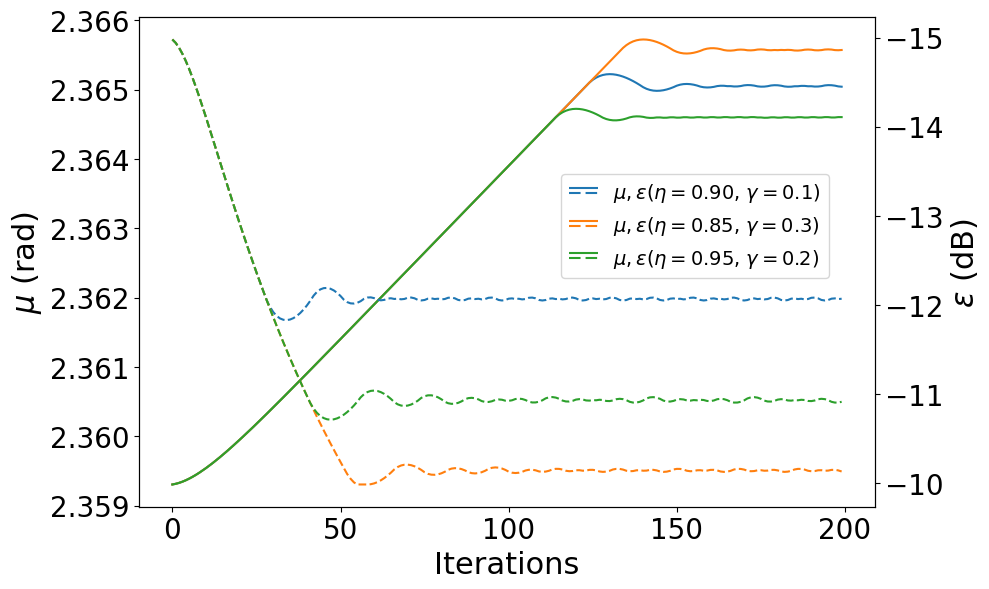

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.lines import Line2D

# Handler for multiline legend entries
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, 
                       width, height, fontsize, trans):
        numlines = len(orig_handle.get_segments())
        xdata = np.linspace(xdescent, width, 2)
        leglines = []
        ydata = np.linspace(ydescent + height, ydescent, numlines+2)[1:-1]
        for i in range(numlines):
            legline = Line2D(xdata, [ydata[i]]*2)
            self.update_prop(legline, orig_handle, legend)
            legline.set_color(orig_handle.get_colors()[i])
            legline.set_linestyle(orig_handle.get_linestyles()[i])
            legline.set_linewidth(orig_handle.get_linewidths()[i])
            legline.set_transform(trans)
            leglines.append(legline)
        return leglines
# -----------------------------------------------------------------
# 1) Load data from each file
# -----------------------------------------------------------------

filename_path1 = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15.txt"
filename_path2 = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15_eta85_gamma3.txt"
filename_path3 = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/simuntaneous/simintaneous_init15_eta95_gamma2.txt"

data1 = np.loadtxt(filename_path1, delimiter="\t", skiprows=1)
data2 = np.loadtxt(filename_path2, delimiter="\t", skiprows=1)
data3 = np.loadtxt(filename_path3, delimiter="\t", skiprows=1)

# Each file has columns [ mu, epsilon, MSE, QFI, CFI ]
mu_1, eps_1 = data1[:, 0], data1[:, 1]
mu_2, eps_2 = data2[:, 0], data2[:, 1]
mu_3, eps_3 = data3[:, 0], data3[:, 1]

# -----------------------------------------------------------------
# 2) (Optional) select how many points to plot
# -----------------------------------------------------------------
to_plot = 200  # e.g. first 200 points, adjust as needed
mu_1 = mu_1[:to_plot]
mu_2 = mu_2[:to_plot]
mu_3 = mu_3[:to_plot]
eps_1 = eps_1[:to_plot]
eps_2 = eps_2[:to_plot]
eps_3 = eps_3[:to_plot]

# -----------------------------------------------------------------
# 3) Convert epsilon to dB
# -----------------------------------------------------------------
eps_db_1 = [epsilon_to_db(eps) for eps in eps_1]
eps_db_2 = [epsilon_to_db(eps) for eps in eps_2]
eps_db_3 = [epsilon_to_db(eps) for eps in eps_3]

# -----------------------------------------------------------------
# 4) Plot mu (left axis) and epsilon in dB (right axis)
# -----------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis for mu
ax1.set_xlabel('Iterations', fontsize=22)
ax1.set_ylabel('$\\mu$ (rad)', fontsize=22)

line1, = ax1.plot(mu_1, label='$\\mu_1$')
line2, = ax1.plot(mu_2, label='$\\mu_2$')
line3, = ax1.plot(mu_3, label='$\\mu_3$')

ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# Secondary axis for epsilon (in dB)
ax2 = ax1.twinx()
ax2.set_ylabel('$\\epsilon$ (dB)', fontsize=22)
line4, = ax2.plot(eps_db_1, linestyle='--', label='$\\epsilon_1$')
line5, = ax2.plot(eps_db_2, linestyle='--', label='$\\epsilon_2$')
line6, = ax2.plot(eps_db_3, linestyle='--', label='$\\epsilon_3$')

ax2.tick_params(axis='y', labelsize=20)
ax2.set_ylim(ax2.get_ylim()[::-1])

# Combine legends from both axes
line_segments = [[(0, 0)], [(0, 0)]]

lc1 = mcol.LineCollection(line_segments, linestyles=['solid', 'dashed'], colors=['#1f77b4']*2)
lc2 = mcol.LineCollection(line_segments, linestyles=['solid', 'dashed'], colors=['#ff7f0e']*2)
lc3 = mcol.LineCollection(line_segments, linestyles=['solid', 'dashed'], colors=['#2ca02c']*2)

ax1.legend([lc1, lc2, lc3],
           ['$\\mu , \\epsilon (\\eta=0.90$, $\\gamma=0.1$)',
            '$\\mu , \\epsilon (\\eta=0.85$, $\\gamma=0.3$)',
            '$\\mu , \\epsilon (\\eta=0.95$, $\\gamma=0.2$)'],
           handler_map={mcol.LineCollection: HandlerDashedLines()},
           fontsize=14, loc='best',bbox_to_anchor=(0.5, 0., 0.45, 0.7),
           handlelength=1.5, handleheight=0.8)


fig.tight_layout()
plt.savefig('combined_plot.png', dpi=1000)
plt.show()